<h1 align="center">Classifying Cancer Tumors using Machine Learning</h1>


<img src="https://michelsonmedical.org/superfiles/2016/08/precision-medicine-dna-art-ucsf-700x300.png" alt="Drawing" style="width: 1000px;height: 250"/>

# Introduction


Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

The workflow is as follows

1. A molecular pathologist selects a list of genetic variations of interest that he/she wants to analyze
2. The molecular pathologist searches for evidence in the medical literature that somehow are relevant to the genetic variations of interest
3. Finally this molecular pathologist spends a huge amount of time analyzing the evidence related to each of the variations to classify them

The goal here is to replace step 3 by a machine learning model.

The Memorial Sloan Kettering Cancer Center (MSKCC) has made available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.

### Objective: 
**Classify the given genetic variations/mutations based on evidence from text-based clinical literature. Predict the effect of Genetic Variants to enable Personalized Medicine**


[Reference to the Kaggle competition](https://www.kaggle.com/c/msk-redefining-cancer-treatment/)

### Constraints

Before we jump into the data, let's define some real world constraints that need to be followed.

* No low-latency requirement
    - As long as the output is obtained in a reasonable amount of time, say within a few minutes, the solution can be accepted.

* Interpretability is extremely important
    - It's not enough that the computer spits out the class to which it thinks a particular genetic mutation belongs. The professional who will be using this program should get a summary of why the computer predicted a particular class. Thus the professional would feel more confident trusting the judgment of the computer and also if needed, can change it. For instance, if the probabilities of a point belonging to two classes is 0.45 and 0.43, the professional can intervene.
    
* Errors can be costly
    - An incorrect classification, especially a false negative (i.e. classifying a malignant (driver) mutation as benign (passenger), can potentially cost someone their life.

## Formulating the Machine Learning task

This is clearly a multiclass classification problem. Target label is `Class` which can take one of 9 different values. The other features `Gene`, `Variation`, `Text` will be considered as dependent variables used by ML algorithms to predict the target variable. Before we start training actual models, we will first decide which of these features are important for machine learning.

### Performace metrics

* Log loss:

Our choice of metric to judge the model's performance would be `log loss`. It is defined as:

<a href="https://www.codecogs.com/eqnedit.php?latex=logloss&space;=&space;-\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{c}y_i_j\log{P_i_j}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?logloss&space;=&space;-\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{c}y_i_j\log{P_i_j}" title="logloss = -\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{c}y_i_j\log{P_i_j}" /></a>


where, 

  $P_{ij}$ : probability that $x_i$ belongs to class $j$.

  $y_{ij}$ :  0 or 1 to indicate if $x_i$ belongs to class $j$

  $n$ : number of data points

  $c$ : number of classes. 

The ideal value of log loss would be 0. But theoretically, it can go upto infinity for a really bad model. Our aim is to minimize it as much as possible. 

* Confusion  Matrix

We will also construct Confusion, Precision and Recall matrices to analyze the model's performance. Since there is class imbalance in our data, accuracy is not the most reliable metric for us.  


In [1]:
import warnings
warnings.filterwarnings("ignore")

Let's begin this fascinating study by importing the modules we need

In [1]:
# general
import time
import re
import pickle
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from collections import Counter, defaultdict
from scipy.sparse import hstack, vstack

# for visualization
import matplotlib.pyplot as plt
import seaborn as sbn

# for preprocessing data
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords

# Text analysis helper libraries
from gensim.summarization import summarize
from gensim.summarization import keywords
import gensim
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from collections import Counter
from matplotlib import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.cluster import KMeans

# for dimensionality reduction
from sklearn.manifold import TSNE

# ML algorithms
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC

from collections import Counter

%reload_ext jupyternotify

C:\Users\ucanr\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<IPython.core.display.Javascript object>

Set default figure size of plots. 

In [62]:
plt.style.use('bmh')
rcParams['figure.figsize'] = (14.5,4.5)

# Exploratory Data Analysis

Let's do some EDA. This is the first step in building a successful data science project. It allows us to determine which variables are important and which are not, and also how they are distributed. 

We start by loading the `training_variants` and `training_text` data in two separate Pandas dataframes and displaying a summary of the two datasets.

We will then analyze each of the three important features `Gene`, `Variation` and `Text` and study how they individually contribute to the ML models. 

In [6]:
# df_variants = pd.read_csv(r'D:\data_science\datasets\medical\training_variants', index_col='ID')
df_variants = pd.read_csv('training_variants', index_col='ID')

There are 3321 entries in the dataframe.

In [7]:
print(df_variants.head(), end = '\n-----------------------------------------\n')
print(df_variants.info())

      Gene             Variation  Class
ID                                     
0   FAM58A  Truncating Mutations      1
1      CBL                 W802*      2
2      CBL                 Q249E      2
3      CBL                 N454D      3
4      CBL                 L399V      4
-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 3 columns):
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(1), object(2)
memory usage: 103.8+ KB
None


Load the other file `training_text` which contains the text reference material used by expert biologists to classify the corresponding data points in file `training_variants`. 

In [10]:
# df_text = pd.read_csv(r'D:\data_science\datasets\medical\training_text',sep='\|\|',skiprows=1, names=['ID', 'Text'], index_col='ID', engine='python')
df_text = pd.read_csv('training_text',sep='\|\|',skiprows=1, names=['ID', 'Text'], index_col='ID', engine='python')

See below that there are 3316 non-null values in this dataset which means - there 5 `ID`s in the `training_variants` file for which there are no `Text` entries. 

In [11]:
print(df_text.head(),end = '\n-----------------------------------------------------------------\n')
print(df_text.info())

                                                 Text
ID                                                   
0   Cyclin-dependent kinases (CDKs) regulate a var...
1    Abstract Background  Non-small cell lung canc...
2    Abstract Background  Non-small cell lung canc...
3   Recent evidence has demonstrated that acquired...
4   Oncogenic mutations in the monomeric Casitas B...
-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
Text    3316 non-null object
dtypes: object(1)
memory usage: 51.9+ KB
None


Let's see what kind of data is stored in the `Text` column of this dataframe. Since each entry is huge(e.g. there are ~37k words in just one of the `Text` cell), I'll print only a small chunk of it.

In [12]:
len(df_text['Text'][1])

36691

See a few words from said `Text` cell. There is a lot special characters and punctuations in this feature. We will have to clean it.

In [13]:
df_text['Text'][1][50:900]

'NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molecule important in normal homeostasis and cancer. We determined the genetic variations of c-CBL, relationship to receptor tyrosine kinases (EGFR and MET), and functionality in NSCLC.  Methods and Findings  Using archival formalin-fixed paraffin embedded (FFPE) extracted genomic DNA, we show that c-CBL mutations occur in somatic fashion for lung cancers. c-CBL mutations were not mutually exclusive of MET or EGFR mutations; however they were independent of p53 and KRAS mutations. In normal/tumor pairwise analysis, there was significant loss of heterozygosity (LOH) for the c-CBL locus (22%, n\u200a=\u200a8/37) and none of these samples revealed any mutation in the remaining copy of c-CBL. The c-CBL LOH also po'

**Concatentate the two dataframes**

Let's combine the two Dataframe so that they're easy to work with. Before using the `concat` function of Pandas, which simply stacks the rows along an axis let's first make sure that the index of both the dataframes is the same. If it is, they can be safely concatenated.

In [14]:
if np.sum(df_text.index == df_variants.index) == df_text.shape[0]:
    print('The index of the two dataframes is equal.')

The index of the two dataframes is equal.


Let's concatenate them!

In [15]:
df = pd.concat([df_variants, df_text], axis=1)

This is how the combined dataframe looks

In [16]:
df.head()

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


**Class Distribution**

Let's see how the data is distributed accross classes. Is it even or uneven?

specifying the order parameter as `df['Class'].value_counts().index.tolist()` ensures that the bars are plotted in decreasing order.

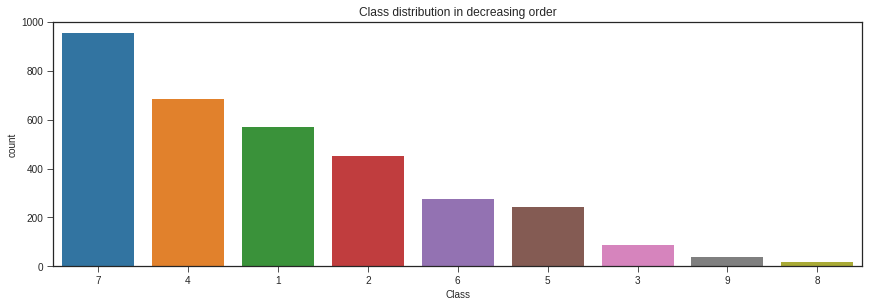

In [17]:
_ = sbn.countplot(data=df, x='Class', order=df['Class'].value_counts().index.tolist(), orient='v')
plt.title('Class distribution in decreasing order')
plt.show()

This dataset is class imbalanced. Class 7 has the most number of datapoints, while class 8 the least.

### Cleaning the data.

`Text` is probably the most crucial column in our dataframe. Because this is the primary reference material researchers use to base their judgement on. Our first task should be to clean it and make it ready so that each data point(row) can be converted into a vector, which in turn will be consumed by various ML algorithms. 

In the raw format, the `Text` columns contains apart from regular stopwords, a lot of terms often found in scientific literature (see list `scientific_jargon` below) which add no value to our models.

In [21]:
scientific_jargon = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”"]

stop_words = set(stopwords.words('english') + list(punctuation) + scientific_jargon)

# Not considering '-' as a stopword because as you can see in the `Text` example above, certain medical terms such as 
# `c-CBL` may lose their context and meaning
stop_words.remove('-')

These are the words which we will remove.

In [22]:
print(stop_words)

{'because', 'in', 'after', '.', 'how', 'very', 'conclusion', "isn't", 'this', "shan't", 'method', 'shan', 'should', '“', '+', 'through', 'using', '<', '/', 'also', 'here', '|', '?', "hasn't", 'the', ';', 'didn', 'a', 'only', 'them', 'having', 'table', 'if', "doesn't", '~', 'an', 'themselves', 'of', "should've", '*', 'than', 'ours', 'yours', 'been', 'up', "hadn't", '%', 'al', 'm', 'such', 'our', 'when', "don't", 're', "shouldn't", "'", '$', '_', "aren't", 'will', 'him', 'yourselves', 'did', 'both', 'mightn', 'its', 'which', 'why', 'wouldn', 'does', 'no', 'during', 'theirs', 'above', 'ourselves', "that'll", 'my', 'myself', 'as', 'ain', 'aren', 'won', '=', 'we', 'result', 'show', 'she', 'so', 'shouldn', 'it', 'were', "it's", 'that', "wouldn't", 'figure', 'those', "needn't", '[', 'not', 'down', 'their', 'isn', 'me', 's', 'then', ']', 'same', '`', 'fig', 'he', 'until', 'they', 'there', 'her', 'off', 'once', 'where', 'wasn', 'y', 'analyze', 'just', 'find', '}', 'have', "you'll", 'to', 'again

#### Check Null values

As expected, there are 5 rows for which the `Text` column is NaN.

In [23]:
df[df.isnull().any(axis=1)]

,Gene,Variation,Class,Text
ID,,,,
1109,FANCA,S1088F,1,NaN
1277,ARID5B,Truncating Mutations,1,NaN
1407,FGFR3,K508M,6,NaN
1639,FLT1,Amplification,6,NaN
2755,BRAF,G596C,7,NaN


Let's drop them

In [24]:
df.dropna(inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3316 entries, 0 to 3320
Data columns (total 4 columns):
Gene         3316 non-null object
Variation    3316 non-null object
Class        3316 non-null int64
Text         3316 non-null object
dtypes: int64(1), object(3)
memory usage: 129.5+ KB


### Function to clean data

The following function takes the entire dataframe as input and the text column, and performs following operations: 

* Removing special characters
* Removing redundant spaces
* Converting all words to lowercase
* Steming the words 

In [26]:
def nlp_preprocessing(df, column):

    stemmer = SnowballStemmer(language='english')

    for index, row in df.iterrows():

        string = ""

        try:

            # replace every special char with empty string
            text_row = re.sub(r'[^\w\s]', '', row[column])

            # replace multiple spaces with single space
            text_row = re.sub('\s+', ' ', text_row)
            # converting all the chars into lower-case.

            text_row = text_row.lower()

            for word in text_row.split():
                # if the word is not a stop word then retain that word from the data
                if not word in stop_words:

                    # sw = word
                    sw = stemmer.stem(word)
                    
                    if len(sw) > 2:
                        string += sw + " "

            df[column][index] = string

        except TypeError:
            print('Error at index {}'.format(index))

    return df

Clean the `Text` column.

In [27]:
%%notify
%%time

df=nlp_preprocessing(df, column='Text')

CPU times: user 9min 53s, sys: 749 ms, total: 9min 54s
Wall time: 9min 54s


<IPython.core.display.Javascript object>

We saw above some words from the Text column of ID=1. Here's some of the text from the same column after it has been cleaned.

In [28]:
df['Text'][1][40:950]

'ncer nsclc heterogen group disord number genet proteom alter ccbl ubiquitin ligas adaptor molecul import normal homeostasi cancer determin genet variat ccbl relationship receptor tyrosin kinas egfr met function nsclc method find archiv formalinfix paraffin embed ffpe extract genom dna ccbl mutat occur somat fashion lung cancer ccbl mutat mutual exclus met egfr mutat howev independ p53 kras mutat normaltumor pairwis analysi signific loss heterozygos loh ccbl locus 837 none sampl reveal mutat remain copi ccbl ccbl loh posit correl egfr met mutat observ sampl select ccbl somat mutat s80nh94i q249e w802 obtain caucasian taiwanes africanamerican sampl respect transfect nsclc cell line increas cell viabil cell motil conclus take overal mutat rate ccbl combin somat missens mutat loh clear ccbl high mutat lung cancer may play essenti role lung tumorigenesi metastasi introduct alon year approxim 219400 peo'

Storing the cleaned dataframe on disk.

In [29]:
f = open('combined_df_cleaned.pkl', 'wb')
pickle.dump(df, f)
f.close()

In [61]:
f = open('combined_df_cleaned.pkl', 'rb')
df=pickle.load(f)
f.close()

## Visualizing via t-SNE

t-SNE is a wonderful technique for visualizing a dataset in two or three dimensions. We will transform the `Text` feature into vectors using a technique called `Doc2Vec` which is just an extension of `W2V`, then significantly reduce the number of dimensions in the data to visualize it using t-SNE. 

We will do these operations in order to see the t-SNE plot:

* Clean `Text` of each row in the dataframe
* Convert `Text` into format suitable for Doc2Vec
* Apply Doc2Vec and obtain the vector representation of `Text`
* Apply t-SNE to reduce the number of dimensions to two.
* Make a scatterplot to visualize clusters

Doc2Vec is an NLP tool for representing a document as a vector. Here, we first convert Text feature of each data point into the `TaggedDocument` format for training using Doc2Vec. The function below takes in a dataframe and converts the text column into this format.

In [30]:
def read_corpus(df, tokens_only=False):
    for i, review in enumerate(df['Text']):
        if tokens_only:
            yield gensim.utils.simple_preprocess(review)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(review), [i])

Call the function on `df`

In [31]:
%%notify
%%time

train_corpus = list(read_corpus(df))

CPU times: user 25.7 s, sys: 896 ms, total: 26.5 s
Wall time: 26.5 s


<IPython.core.display.Javascript object>

As printed below, each point in the train corpus is of type `TaggedDocument` and there are `3316` such points - one for each `Text`. 

In [32]:
type(train_corpus[1])

gensim.models.doc2vec.TaggedDocument

In [33]:
len(train_corpus)

3316

Time to convert text into vectors! Define a `doc2vec` model with vector size 100. i.e. each `Text` will be represented by a vector having 100 dimensions. 

In [35]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=5, epochs=45, workers=2)

Build vocabulary and then train the model.

In [36]:
%%notify
model.build_vocab(train_corpus)

<IPython.core.display.Javascript object>

In [37]:
model

In [40]:
%%notify
%%time

model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 41min 53s, sys: 8.24 s, total: 42min 1s
Wall time: 21min 26s


<IPython.core.display.Javascript object>

We need just the `Text` vectors from the dataframe `df`. Let's separate them.

In [41]:
%%notify
%%time

w2v_text = np.zeros((1,100))

for doc in df['Text']:
    arr = np.reshape(model.infer_vector(str(doc).split()), (1,-1))
    w2v_text=np.vstack([w2v_text, arr])

w2v_text = np.delete(w2v_text, (0), axis=0)

CPU times: user 23min 5s, sys: 518 ms, total: 23min 6s
Wall time: 23min 6s


<IPython.core.display.Javascript object>

Save to disk for later use.

In [42]:
f = open('w2v_text_vector.pkl', 'wb')
pickle.dump(w2v_text, f)
f.close()

In [ ]:
# f = open('w2v_text_vector.pkl','rb')
# w2v_text = pickle.load(f)
# f.close()

As expected the vector `w2v_text` has 3316 documents each represented as a 100 dimensional vector.

In [43]:
w2v_text.shape

(3316, 100)

Standardize the data

In [44]:
scaler = StandardScaler()
w2v_text_std = scaler.fit_transform(w2v_text)

Call t-SNE

In [45]:
%%notify
%%time

tsne = TSNE(n_components=2, random_state=31, perplexity=55, learning_rate = 200)

w2v_text_tsne = tsne.fit_transform(w2v_text_std)

CPU times: user 34.6 s, sys: 56 ms, total: 34.6 s
Wall time: 34.9 s


<IPython.core.display.Javascript object>

The dimensions have been reduced to just two.

In [46]:
w2v_text_tsne.shape

(3316, 2)

Create a datframe to fascilitate convenient use of `seaborn`. 

In [47]:
w2v_text_tsne = np.vstack((w2v_text_tsne.T, df['Class'])).T
df_w2v_text_tsne = pd.DataFrame(w2v_text_tsne, columns=['First Dimension', 'Second Dimension', 'Class'])

In [48]:
df_w2v_text_tsne.head()

,First Dimension,Second Dimension,Class
0,-2.896205,0.649359,1.0
1,44.190998,-21.790115,2.0
2,44.189556,-21.794621,2.0
3,27.047947,25.105576,3.0
4,48.028137,-22.191717,4.0


Plot the clusters!

[]

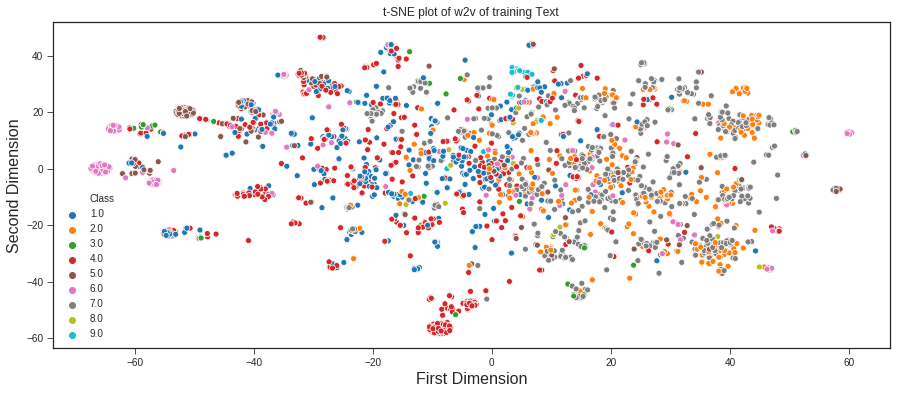

In [49]:
plt.subplots(figsize=(15,6))
ax = sbn.scatterplot(data=df_w2v_text_tsne, x='First Dimension', y='Second Dimension', hue='Class', palette='tab10', legend='full')
ax.set_xlabel('First Dimension', fontsize=16)
ax.set_ylabel('Second Dimension', fontsize=16)
ax.set_title('t-SNE plot of w2v of training Text')
plt.plot()

There are some distinguishable clusters in the data, but not as good as we'd like. Still, observe the red, pink and orange clusters representing classes 4, 6, 2 respectively. Note that reducing the dimensions also results in loss of information. i.e. a hundred dimensional vector is better at separating the classes than a two dimensional one.

### KMeans

Let's also apply KMeans clustering to the t-SNE obtained vectors. And see how it _thinks_ the classes are distributed. 

In [53]:
kmeans = KMeans(n_clusters=9, random_state=13, n_jobs=2)
kmeans_predictions=kmeans.fit_predict(w2v_text_tsne)

In [54]:
df_w2v_text_tsne['kmeans_pred'] = kmeans_predictions + 1

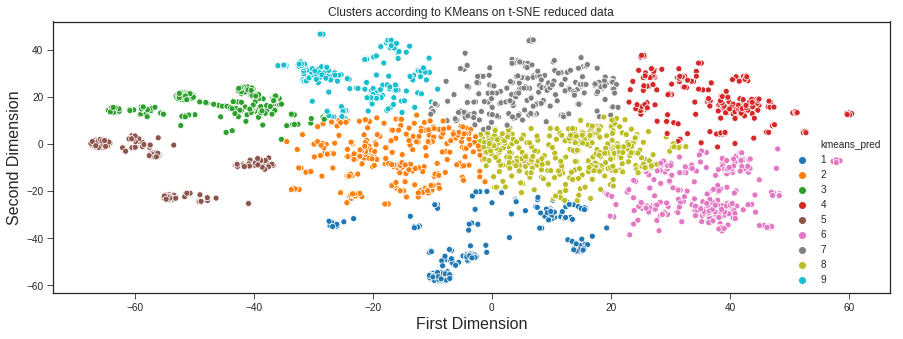

In [55]:
plt.subplots(figsize=(15,5))
ax = sbn.scatterplot(data=df_w2v_text_tsne, x='First Dimension', y='Second Dimension', hue='kmeans_pred', palette='tab10', legend='full')
ax.set_xlabel('First Dimension', fontsize=16)
ax.set_ylabel('Second Dimension', fontsize=16)
ax.set_title('Clusters according to KMeans on t-SNE reduced data')
plt.show()

## Train, CV and Test sets

Split the data in 80% train, 20% test. Again split the train set into train and CV in the ratio 80:20. Thus giving the following sizes

* 64% train
* 16% CV
* 20% Test

These sets will be used for training models, cross validating hyperparameters and testing the performance of the models.

In [56]:
y_true = df['Class'].values
df['Gene'] = df['Gene'].str.replace('\s+', '_')
df['Variation'] = df['Variation'].str.replace('\s+', '_')

Note that we are stratifying the class labels `y` which will maintain its proportion in all sets.

In [57]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
df_X_train_cv, df_X_test, y_train_cv, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
df_X_train, df_X_cv, y_train, y_cv = train_test_split(df_X_train_cv, y_train_cv, stratify=y_train_cv, test_size=0.2)

Let's see how the data are distributed among the three sets.

In [58]:
table_size = PrettyTable()
table_size.field_names = ['X','#size(X)','y', '#size(y)']
table_size.add_row(['df_X_train', df_X_train.shape[0],'y_train', y_train.shape[0]])
table_size.add_row(['df_X_cv', df_X_cv.shape[0], 'y_cv', y_cv.shape[0]])
table_size.add_row(['df_X_test', df_X_test.shape[0], 'y_test', y_test.shape[0]])
print(table_size)

+------------+----------+---------+----------+
|     X      | #size(X) |    y    | #size(y) |
+------------+----------+---------+----------+
| df_X_train |   2121   | y_train |   2121   |
|  df_X_cv   |   531    |   y_cv  |   531    |
| df_X_test  |   664    |  y_test |   664    |
+------------+----------+---------+----------+


### Distribution of classes in Train/Test/Cv datasets

We plotted a bar graph above to see the class distribution on full data. Let's see now if the propotion of class labels is maintained across all sets.

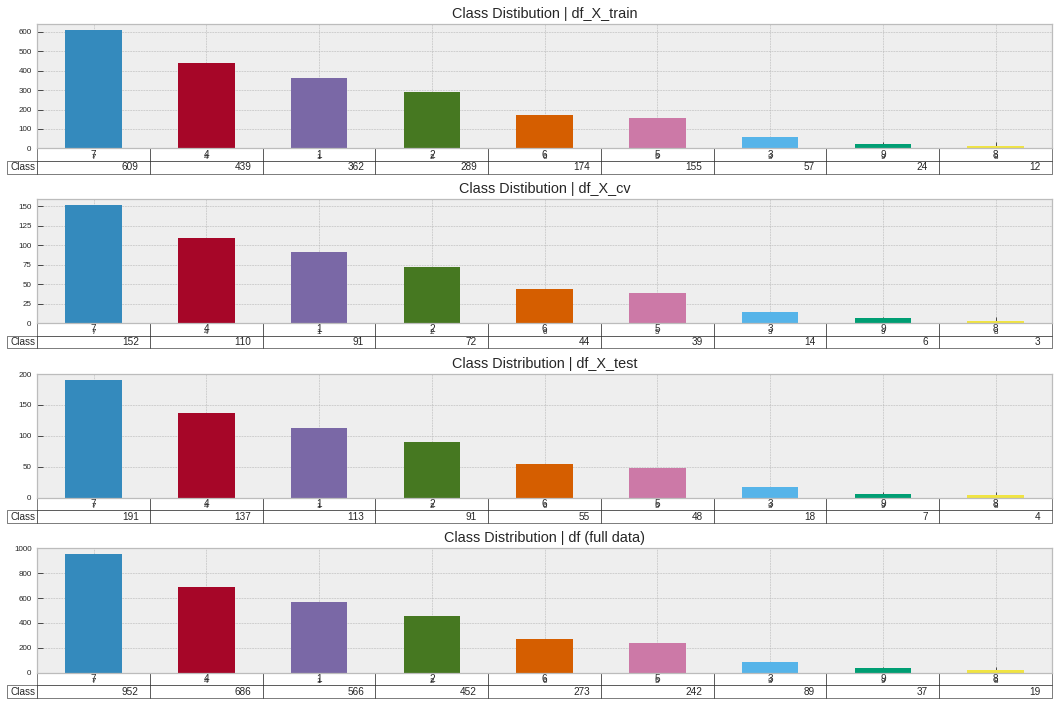

In [65]:
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15,8))
plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
df_X_train['Class'].value_counts().plot(kind='bar', x='classes', y='count', rot=0, table=True)
plt.title('Class Distibution | df_X_train')

plt.subplot(4,1,2)
df_X_cv['Class'].value_counts().plot(kind='bar', rot=0, table=True)
plt.title('Class Distibution | df_X_cv')

plt.subplot(4,1,3)
df_X_test['Class'].value_counts().plot(kind='bar', rot=0, table=True)
plt.title('Class Distribution | df_X_test')

plt.subplot(4,1,4)
df['Class'].value_counts().plot(kind='bar', rot=0, table=True)
plt.title('Class Distribution | df (full data)')

plt.tight_layout(pad=2.1)

It is! The first three plots are for sets train, cv and test repectively. The last plot is for the original unsplit data.

### Function to plot Confusion, Precision and Recall Matrix

We will see ahead how to read these matrices. 

In [66]:
def plot_confusion_matrix(y_test, y_predicted, model):
    
    try:
        # cm = 9x9 matrix, each cell (i,j) represents number of points of class i are predicted class j
        cm = confusion_matrix(y_test, y_predicted)

        labels = [1,2,3,4,5,6,7,8,9]                
        plt.figure(figsize=(15,4))
        sbn.heatmap(cm, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Actual Class')
        plt.title("Confusion matrix | model = {}".format(model))
        plt.show()

        # Precision Matrix
        pm =(cm/cm.sum(axis=0))
        plt.figure(figsize=(15,4))
        sbn.heatmap(pm, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Actual Class')
        plt.title('Precision Matrix (Column Sum = 1) | model = {}'.format(model))
        plt.show()

        # Recall matrix
        rm = (((cm.T)/(cm.sum(axis=1))).T)
        plt.figure(figsize=(15,4))
        sbn.heatmap(rm, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Actual Class')
        plt.title('Recall Matrix (Row Sum = 1) | model = {}'.format(model))
    
    except:
        print('An Exception was encountered.')
    plt.show()

### Predicting using Random Model

Let's create a random model. It is a model which *guesses* to which class a point may belong, without taking into consideration any data. The score of this model will be treated as a benchmark.

For every model that we train for this problem, it's our requirement that the output tells us the probability of a point belonging to all the nine classes. We'll try to abide by it as much as possible.

For the Random Model, we generate the 9 class probabilites randomly such that they sum to 1.

Since this model literally makes random guesses about a point's true class, we expect every other model to perform better than this. This is just a kind of sanity test. So in case we encounter a `logloss` value that is even worse that the Random model, we'll know something's wrong.

In [67]:
df_X_test.shape

(664, 4)

In [68]:
df_X_cv.shape

(531, 4)

Let's create a table which will store the result of each of our models.

In [45]:
table = PrettyTable()
table.field_names = ['#','Feature','Data Set','Feature Type','Hyperparameter', 'Algorithm','logloss']

#### Matrix for random model

Log loss on Test Data using Random Model 2.4807895501379615



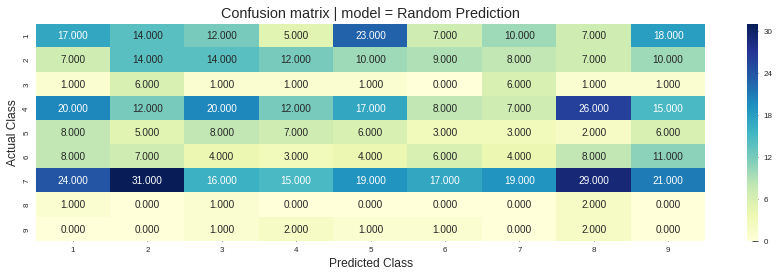

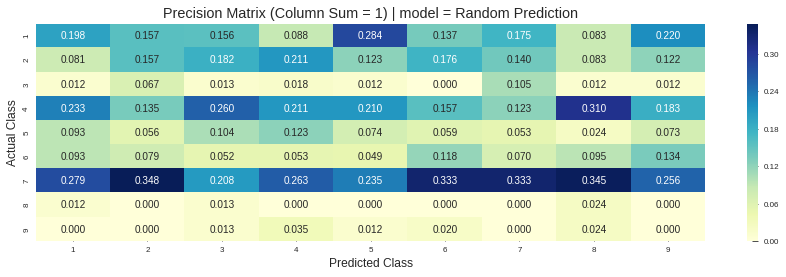

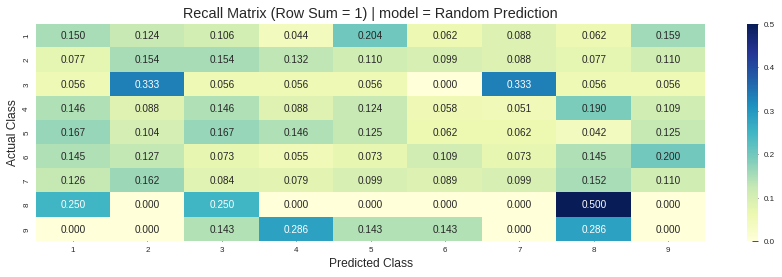

In [125]:
test_data_len = df_X_test.shape[0]
cv_data_len = df_X_cv.shape[0]

# we create an output array that has exactly same size as the CV data
cv_random_predicted_y = np.zeros((cv_data_len,9))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_random_predicted_y[i] = rand_probs/np.sum(rand_probs)

# Test-Set error.
test_random_predicted_y = np.zeros((test_data_len,9))

for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_random_predicted_y[i] = rand_probs/np.sum(rand_probs)
    
print("Log loss on Test Data using Random Model",log_loss(y_test,test_random_predicted_y, eps=1e-15), end = '\n\n')

# Get the index of the class having the highest probability
predicted_y =np.argmax(test_random_predicted_y, axis=1)

# Since predicted_y contains classes starting from 0, add 1 to all to shift the index by 1
plot_confusion_matrix(y_test, predicted_y+1, "Random Prediction")

In [46]:
table.add_row(['1','NA', 'Test', 'NA', 'NA', 'Random Prediction', 2.48])

### Understanding Precision, Recall and Confusion Matrix.

1. Confusion Matrix

    * Diagonal cells contain correctly classified points. e.g. cell `[4,4]=15` says there are 15 points such that actual class is 4 and predicted class is also 4. That means - ideally, we'd want the diagonal elements of this matrix to be very large.

    * Off diagonal cells `[row i, column j]` - there are `#cell` points such that the actualy class is `i` but the model predicted it to be class `j`
2. Precision Matrix (Column sum = 1)
    * Diagonal cells contain precision for each of the classes
    * Off diagonal cells `[row i, column j]` - of all the points predicted to be in class `j`, `#cell` points actually belong to class `i`  

3. Recall Matrix (Row sum = 1)
    * Diagonal cells contain recall for each of the classes
    * Off diagonal cells `[row i, column j]` - of all the points that actually belong to class `i`, `#cell` points were predicted to belong to class `j` by the model. 
    
    
For the random model, as expected, we don't see ideal diagonal entries.

#### Log loss for Random Prediction Model

As expected, the logloss for Random Model is around 2.5 which is neither great nor terrible.

### Laplace/Additive smoothing 

Laplace smoothing (not to be confused with Laplacian smoothing) is way of avoiding overfitting, by doing a bias-variance tradeoff. It happens occasionally that a word comes up that was not seen in the training data. This is taken care of by adding $\alpha$ which is called the smoothing factor to the probability of finding a feature value in the training data. Thus, even if a word not found in training data is encountered, the probability does not become 0.  

For this problem, in the formula, $v$ is a vector of size 1 x 9. Where, 
* $x_i$ = number of occurences of word $x_i$ in a class
* $N$ = total occurences of the word $x_i$ in all the classes 
* $\alpha$ = smoothing parameter
* $d$ = Number of dimensions, in this case 9

$$v_i=\frac{x_i + \alpha}{N + \alpha*d}$$

Let's define a few useful functions.

* get_gv_feature() : returns the response coded features
* get_gv_fea_dict(): Helper function used by the above function
* cdf() : Generates the x and y limits of the cumulative distribution function
* plot_counts_and_cdf() : Plots the counts in decreasing order and the CDF

In [127]:
df.Variation.value_counts()[:5]

Truncating_Mutations    92
Deletion                74
Amplification           70
Fusions                 34
Overexpression           6
Name: Variation, dtype: int64

In [73]:
# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):

    value_count = df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):

            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    
    return gv_dict


# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])

    return gv_fea

In [76]:
def cdf(data):
    """
    compute ECDF for a one dimensional array of measurements.
    The y data of the ECDF go from 1/n to 1 in equally spaced increments.
    the end value in np.arange() is not inclusive. Therefore, np.arange() will need to go from 1 to n+1
    """
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1) / n
    return x,y

In [77]:
def plot_counts_and_cdf(value_counts, feature):
    
    plt.subplot(1,2,1)
    _ = value_counts.plot(figsize=(15,4.5))
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('#points belonging to each {} | sorted'.format(feature), fontsize=16)
    plt.subplot(1,2,2)
    
    x,y = cdf(value_counts)
    # cdf=np.cumsum(value_counts.values/np.sum(value_counts))
    plt.plot(x,y, linestyle='none', marker='.')
    plt.title('CDF of number of {}'.format(feature), fontsize=16)
    plt.ylabel('Cumulative fraction', fontsize=14)
    plt.xlabel('Count of genes', fontsize=14)
    plt.margins(0.03)
    

## Univariate Analysis: Gene




Gene is a categorical feature. Let's ask some simple questions about this feature.

Which genes are found the most in this data?

In [74]:
gene_value_counts = df_X_train['Gene'].value_counts()
gene_value_counts.head(10)

BRCA1     163
TP53      109
EGFR       93
PTEN       85
BRCA2      80
BRAF       63
KIT        60
ALK        45
ERBB2      44
PIK3CA     39
Name: Gene, dtype: int64

How many unique genes are there in the data?

In [75]:
len(gene_value_counts)

234

How are the genes distributed across our data?

* The graph to the left shows the number of times each gene is encountered in the decreasing order. Some of the genes are found only one or two times.

* The graph to the right shows the cumulative distribution function (CDF). We can observe from it that out of 234 total genes, about 25 genes comprise 90% of the data.

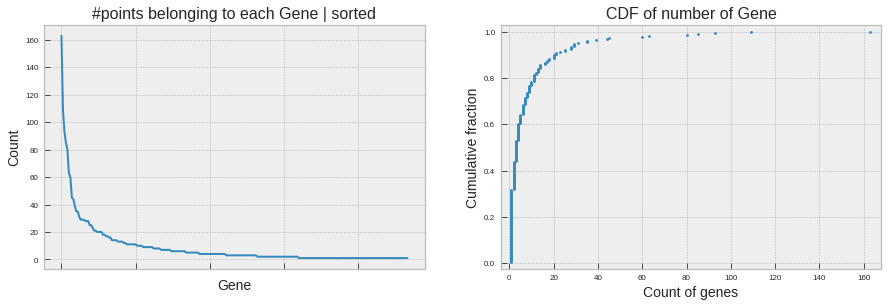

In [78]:
plot_counts_and_cdf(gene_value_counts, 'Gene')

#### What are the top 5 genes found in each class?

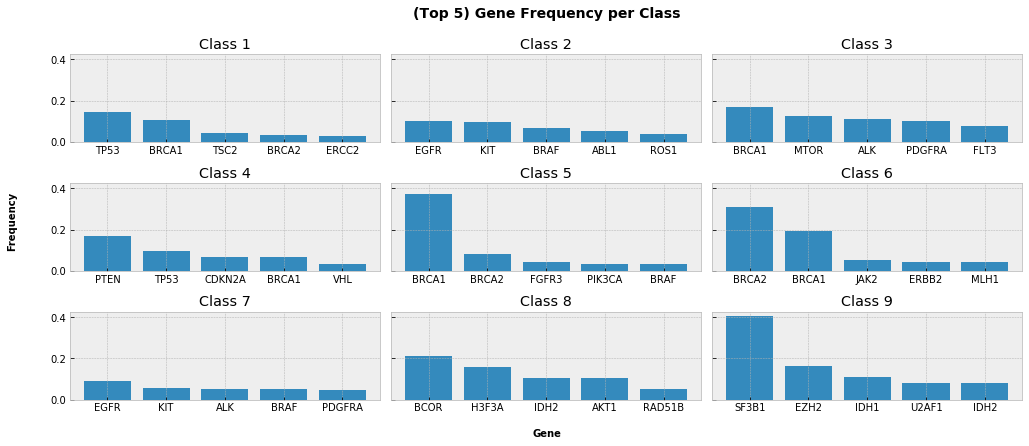

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(15,6))

# Normalize value counts for better comparison
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

for idx, g in enumerate(df.groupby('Class')):
    label, val = normalize_group(g[1]["Gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5],
           tick_label=label[:5])
    
    ax.set_title("Class {}".format(g[0]))
    
fig.text(0.5, 0.97, '(Top 5) Gene Frequency per Class', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

### Featurizing Gene

* One hot Encoding
* Response coding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests and KNN since RF doesn't work well when number of features is very large.

In [80]:
%%notify
%%time

# response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", df_X_train))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", df_X_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", df_X_cv))

CPU times: user 9.8 s, sys: 84.3 ms, total: 9.88 s
Wall time: 9.72 s


<IPython.core.display.Javascript object>

The shapes of the train, CV and test sets for response-coded `Gene` feature.

In [83]:
train_gene_feature_responseCoding.shape, cv_gene_feature_responseCoding.shape,  test_gene_feature_responseCoding.shape

((2121, 9), (531, 9), (664, 9))

Let's standardize the data with Response Coding. This means scaling each feature to have 0 mean and unit variance.

In [84]:
scaler = StandardScaler()
train_gene_feature_responseCoding = scaler.fit_transform(train_gene_feature_responseCoding)
cv_gene_feature_responseCoding = scaler.transform(cv_gene_feature_responseCoding)
test_gene_feature_responseCoding = scaler.transform(test_gene_feature_responseCoding)

#### One Hot Encoding Gene with Tfidf

One Hot Encoding is generally obtained with _CountVectorizer_, but we'll be using _TfidfVectorizer_. The only difference it will make is instead of the count, there will be Tfidf value for all features. 

In [85]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(df_X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(df_X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(df_X_cv['Gene'])

Standardize Gene data with features : On Hot Encoding

In [86]:
scaler = StandardScaler(with_mean=False)
train_gene_feature_onehotCoding = scaler.fit_transform(train_gene_feature_onehotCoding)
cv_gene_feature_onehotCoding = scaler.transform(cv_gene_feature_onehotCoding)
test_gene_feature_onehotCoding = scaler.transform(test_gene_feature_onehotCoding)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 234)

In [87]:
len(gene_vectorizer.get_feature_names())

234

## How good is a feature for predicting y?

In order to decide how important a feature is for predicting the class label, one of the techniques is to train a model using only that feature and analyze the performance. If the model performs better than the random model we saw above, the feature is worth including in the final set of features that we will actually use for predicting the class labels.

So let's start with the feature `Gene`, we will build a logistic regression model using only Gene (one hot encoded) to predict y_i.

### Few important functions
train_cross_validate_on_X() : 

It takes train and CV data and a set of hyper-parameters and fits the specified model to the data and returns the cross validation log loss values 


In [280]:
def train_cross_validate_on_X(X_train, X_cv, model, hyper_parameters,class_weight=None):
    
    cv_log_loss_array = []
    
    if model == 'logistic regression':
        
        for c in hyper_parameters:

            lr = LogisticRegression(C=c, class_weight=class_weight)
            lr.fit(X_train, y_train)
            predicted_probabilities = lr.predict_proba(X_cv)
            cv_log_loss_array.append(log_loss(y_cv, predicted_probabilities, labels=lr.classes_, eps=1e-15))
        
        return cv_log_loss_array
    
    elif model == 'naive bayes':
        
        for a in hyper_parameters:

            nb = MultinomialNB(alpha=a)
            nb.fit(X_train, y_train)
            predicted_probabilities = nb.predict_proba(X_cv)
            cv_log_loss_array.append(log_loss(y_cv, predicted_probabilities, labels=nb.classes_, eps=1e-15))

        return cv_log_loss_array
    
    elif model == 'support vector machines':
        
        for c in hyper_parameters:

            svm = LinearSVC(C=c)
            svm.fit(X_train, y_train)
            cal_clf = CalibratedClassifierCV(svm, method="sigmoid", cv='prefit')
            cal_clf.fit(X_train, y_train)
            predicted_probabilities = cal_clf.predict_proba(X_cv)
            cv_log_loss_array.append(log_loss(y_cv, predicted_probabilities, labels=svm.classes_, eps=1e-15))

        return cv_log_loss_array
        
    
    elif model == 'random forests':
        
        train_and_cv_combined = vstack([X_train, X_cv])
        clf = GridSearchCV(RandomForestClassifier(), hyper_parameters, cv = 4, scoring='neg_log_loss', n_jobs = 2)
        clf.fit(train_and_cv_combined, np.append(y_train, y_cv))

        print('best log los: ', clf.best_score_, 'best parameters: ', clf.best_params_)

The function below finds the important features by weight using the `coef_` attribute on models fit on train data. 

It returns a dictionary containing 9 keys - one for each class. The values are the lists containing the important features for classification of a class sorted in order most important to least important.

e.g. by using `feature_importance['4']`, I can get the important features of class 4. This will help in providing the reasons of classification i.e. for interpreting the output of the model.

In [90]:
def get_important_features(X_train, X_cv, tfidf_vectorizer, hyperparameters, model ):
    
    # calibrate_flag = True if model == 'SVM' else False
    
    cv_log_loss_array = []
    
    if model == 'logistic regression':
        
        for h in hyperparameters: 
        
            clf = LogisticRegression(C=h)
            clf.fit(X_train, y_train)
            predicted_probabilities = clf.predict_proba(X_cv)
            cv_log_loss_array.append(log_loss(y_cv, predicted_probabilities, labels=clf.classes_, eps=1e-15))

    elif model == 'naive bayes':
        
        for h in hyperparameters:

            clf = MultinomialNB(alpha=h)
            clf.fit(X_train, y_train)
            predicted_probabilities = clf.predict_proba(X_cv)
            cv_log_loss_array.append(log_loss(y_cv, predicted_probabilities, labels=clf.classes_, eps=1e-15))

    elif model == 'support vector machines':
        
        for h in hyperparameters:
            
            clf = LinearSVC(C=h)
            clf.fit(X_train, y_train)
            cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
            cal_clf.fit(X_train, y_train)
            predicted_probabilities = cal_clf.predict_proba(X_cv)
            cv_log_loss_array.append(log_loss(y_cv, predicted_probabilities, labels=clf.classes_, eps=1e-15))
  
    best_h = hyperparameters[np.argmin(cv_log_loss_array)]

    if model == 'logistic regression' :
        
        best_clf = LogisticRegression(C=best_h)
    
    elif model == 'naive bayes':
            
        best_clf = MultinomialNB(alpha=best_h)
    
    elif model == 'support vector machines':
        
        best_clf = LinearSVC(C = best_h)
        
    # lr = LogisticRegression(C=best_C)
    best_clf.fit(X_train, y_train)

    feature_importances_dict = {}

    for klass in range(0,9):
        feature_importances = dict(zip(tfidf_vectorizer.get_feature_names(), best_clf.coef_[klass]))
        top_feature_weights = np.sort(list(feature_importances.values()))[::-1]
        reverse_feature_importance = {v:k for k,v in feature_importances.items()}

        feature_importances_dict[str(klass+1)] = []

        for weight in top_feature_weights:
            feature_importances_dict[str(klass+1)].append(reverse_feature_importance[weight])
    
    return (cv_log_loss_array, feature_importances_dict)

The following function gives the reasons of classification of a test datapoint

In [89]:
def show_reasons_of_classification(X_test, test_point_index, clf,
                                   imp_feature_GENE, imp_feature_VARIATION,
                                   imp_feature_TEXT, top_n):

    class_probabilities = clf.predict_proba(X_test[test_point_index])
    predicted_class = np.argmax(class_probabilities) + 1

    gene_of_test_point = df_X_test.reset_index().iloc[test_point_index]['Gene']
    variation_of_test_point = df_X_test.reset_index(
    ).iloc[test_point_index]['Variation']
    text_of_test_point = df_X_test.reset_index().iloc[test_point_index]['Text']
    actual_class_of_test_point = df_X_test.reset_index(
    ).iloc[test_point_index]['Class']

    print('{}Test Query Analysis{}'.format('*'*30, '*'*30),end='\n\n')
    print('Test data point: #', test_point_index, end='\n=============\n')

    print(
        'Predicted Probabilities of each class: \n\n{}'.format(
            class_probabilities),
        end='\n=============\n')

    print(
        'Actual Class is: ',
        actual_class_of_test_point,
        '\nPredicted Class is',
        predicted_class,
        end='\n=============\n')

    print(
        'Class {} was predicted because, among the top {} words for this class, we found that:'
        .format(predicted_class, top_n),
        end='\n=============\n')

    # print(gene_of_test_point, '|', variation_of_test_point)
    
    # Check if GENE of test point is an important feature.
    if gene_of_test_point in set(imp_feature_GENE[str(predicted_class)]):#[:top_n]):
        idx = imp_feature_GENE[str(predicted_class)].index(gene_of_test_point)
        print('Gene [', gene_of_test_point, '] is the [', idx,
              '] st/th most important gene for class \
        ', predicted_class)
    if variation_of_test_point in set(imp_feature_VARIATION[str(
            predicted_class)]):#[:top_n]):
        idx = imp_feature_VARIATION[str(predicted_class)].index(
            variation_of_test_point)
        print('Variation [', variation_of_test_point, '] is the [', idx,
              '] st/th most important variation for class \
        ', predicted_class)

    word_counter = Counter()

    for word in text_of_test_point.split():
        if word in imp_feature_TEXT[str(predicted_class)][:top_n]:
            #print('found : [', word, '] which is the [', imp_feature_TEXT[str(predicted_class)][:top_n].index(word), '] th/st most important word in TEXT')
            word_counter[word] += 1

    sorted_rank_of_words = sorted(
        imp_feature_TEXT[str(predicted_class)][:top_n].index(x[0])
        for x in word_counter.items())

    for rank in sorted_rank_of_words:

        word = imp_feature_TEXT[str(predicted_class)][rank]

        print(
            "TEXT: [{}] appeared [{}] times which is the [#{}] most important word".
            format(word, word_counter[word], rank))

This function is just like `get_important_features()` but for Random Forests

In [277]:
# hyperparameters

def get_important_features_RF(X_train, X_cv, tfidf_vectorizer):
    
    # cv_log_loss_array = []
    
    hyp_par = {
                'max_depth':[3,5 , 7,9,11],
                'n_estimators' : [ 90, 110, 130, 150, 200, 300]
    }
    
    train_and_cv_combined = vstack([X_train, X_cv])
    
    clf = GridSearchCV(RandomForestClassifier(), hyp_par, cv = 4, scoring='neg_log_loss', n_jobs = 2)
    clf.fit(train_and_cv_combined, np.append(y_train, y_cv))
    
    feature_importances = dict(zip(tfidf_vectorizer.get_feature_names(), clf.best_estimator_.feature_importances_))
    top_feature_weights = np.sort(list(feature_importances.values()))[::-1]
    reverse_feature_importance = {v:k for k,v in feature_importances.items()}
    
    feature_importances_list = []

    for weight in top_feature_weights:
            feature_importances_list.append(reverse_feature_importance[weight])
            
    # save list to each class. This is to be consistent with the other function
    feature_importances_dict = {str(i):feature_importances_list for i in range(1,10) }
    
    return (cv_log_loss_array, feature_importances_dict)

The function below shows the logloss on Cross Validation data for each value of hyper-parameter.

In [130]:
def plot_hypP_vs_logloss(hyperparameters, cv_log_loss_array, parameter_name):
    
    plt.plot(hyperparameters, cv_log_loss_array,c='r', marker='.', linestyle='none', markersize=10)   
    plt.grid()
    plt.title("Cross Validation Error for each Hyperparameter")
    plt.xlabel(parameter_name)
    plt.ylabel("Log Loss")
    plt.tight_layout()
    plt.grid()
    plt.show()

### How Good is feature GENE?

Let's begin the univariate analysis of GENE. To start, I'll get the important gene features using Logistic Regression.

In [128]:
C = [10 ** x for x in range(-6, 2)]

cv_log_loss_array, important_features_GENE_LR = get_important_features(X_train=train_gene_feature_onehotCoding, 
                                                                       X_cv=cv_gene_feature_onehotCoding, 
                                                                       tfidf_vectorizer=gene_vectorizer, 
                                                                       hyperparameters=C, 
                                                                       model='logistic regression')

Logloss on Cross Validation data using Logistic Regression on `Gene`

In [129]:
print('For feature Gene using 1-Hot Encoding on Cross Validation data...\n')
for k, v in dict(zip(C, cv_log_loss_array)).items():
    print(' C = {}, logloss: {}'.format(k, v))

best_C = C[np.argmin(cv_log_loss_array)]    
    
print('\nBest C found was:', best_C, 'with log loss: ', np.min(cv_log_loss_array))

For feature Gene using 1-Hot Encoding on Cross Validation data...

 C = 1e-06, logloss: 2.19678512846901
 C = 1e-05, logloss: 2.192840537394099
 C = 0.0001, logloss: 2.154571329939932
 C = 0.001, logloss: 1.8890398449557138
 C = 0.01, logloss: 1.3943020284419918
 C = 0.1, logloss: 1.2353241972855127
 C = 1, logloss: 1.2986488132063956
 C = 10, logloss: 1.4137922892418326

Best C found was: 0.1 with log loss:  1.2353241972855127


The result is not bad at all! the best logloss on CV data obtained was `1.23` for C = 0.1.
Let's also plot the observations

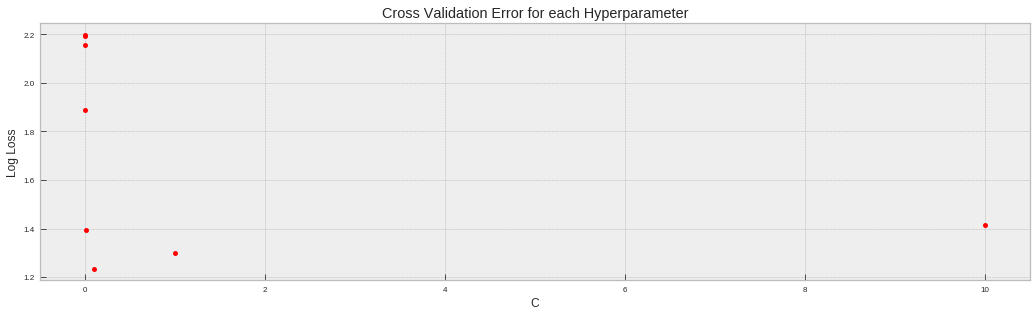

In [131]:
plot_hypP_vs_logloss(C, cv_log_loss_array, 'C')

#### Logloss for Train, Test and CV data using the best hyper-parameter found

Having found the best C using Cross Validation, it's time to test it on the `test` dataset. But we'll also predict the labels on Train data to check if the model's overfitting.

In [132]:
lr = LogisticRegression(C=best_C)
lr.fit(train_gene_feature_onehotCoding, y_train)

logloss_train = log_loss(y_train, lr.predict_proba(train_gene_feature_onehotCoding))
logloss_cv = log_loss(y_cv, lr.predict_proba(cv_gene_feature_onehotCoding))
logloss_test = log_loss(y_test, lr.predict_proba(test_gene_feature_onehotCoding))

# print(logloss_train, logloss_cv, logloss_test)

print('For Logistic Regression using One-Hot-Encoding on feature GENE...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)

For Logistic Regression using One-Hot-Encoding on feature GENE...
****************************
logloss on train data:  0.9347594454474629
logloss on CV data:  1.2353241972855127
logloss on Test data:  1.2346636948711256


Log loss on test isn't too far away from train and CV. Hence it's not overfitting much. Also, since it's much lower than the Random model, we can conclude that feature `Gene` is certainly useful in predicting the class label.

In [47]:
table.add_row(['2','Gene', 'Test', 'One Hot Encoding', 'best C: 0.1', 'Logistic Regression', 1.234])

## Univariate analysis : Variation 

It's a categorical feature like gene. Let's do a similar analysis.

In [134]:
variations_value_counts = df_X_train['Variation'].value_counts()
print('Number of Unique Variations :', variations_value_counts.shape[0])
# the top 10 variations that occured most
print(variations_value_counts.head(10))

Number of Unique Variations : 1923
Truncating_Mutations    60
Deletion                48
Amplification           40
Fusions                 20
Overexpression           5
G12V                     4
Q61L                     3
T58I                     3
Y42C                     2
P130S                    2
Name: Variation, dtype: int64


#### How many unique Variations?

In [135]:
len(variations_value_counts)

1923

#### How is `Variation` distributed?

It's very skewed.
Looking at the graphs below, there are `4` variations which appear in a lot of points, while the others are mostly unique.

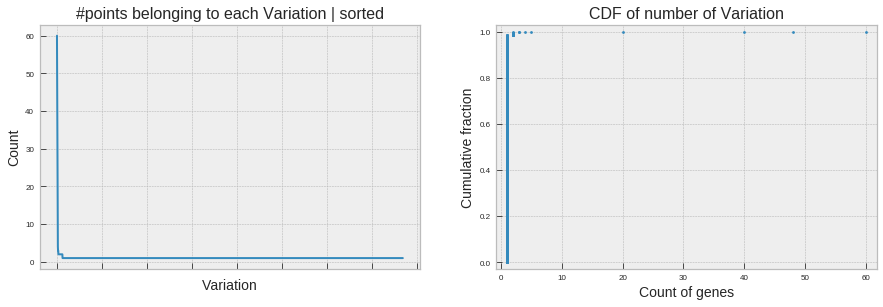

In [136]:
plot_counts_and_cdf(variations_value_counts, 'Variation')

#### Top 5 Variations in each class 

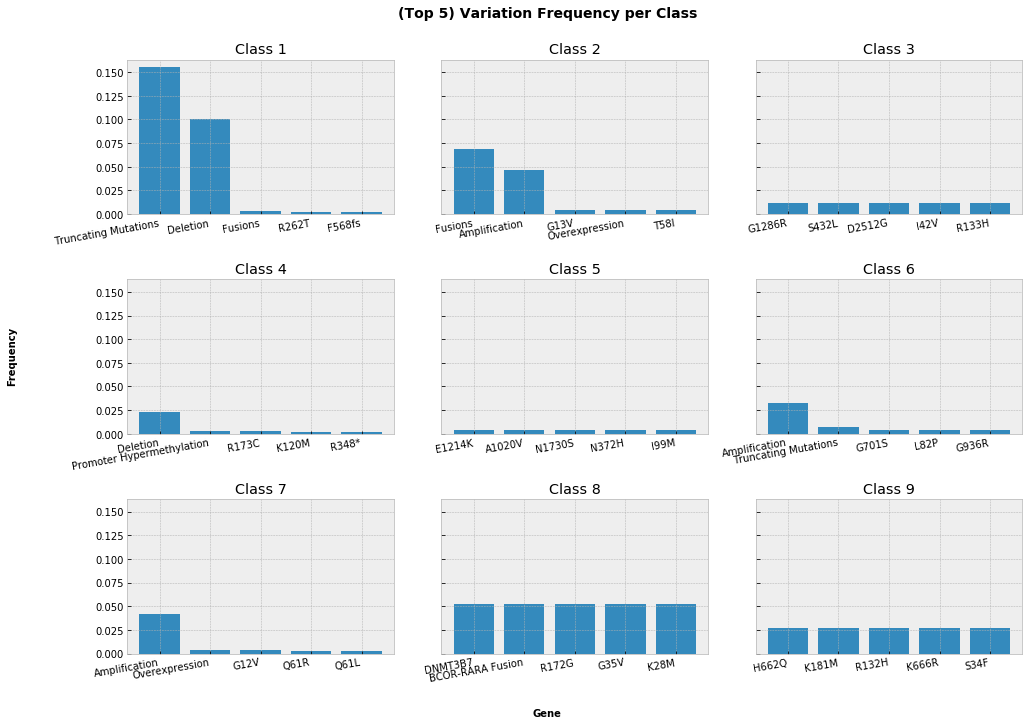

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(15,10))

# Normalize value counts for better comparison
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

for idx, g in enumerate(df.groupby('Class')):
    label, val = normalize_group(g[1]["Variation"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5],tick_label=label[:5])
    # plt.xticks(rotation=45)
    ax.set_title("Class {}".format(g[0]))
    plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='right')
    
    
fig.text(0.5, 0.97, '(Top 5) Variation Frequency per Class', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

## Featurizing Variation

Like we did for `Gene`, we will convert the textual data of `Variation` into numerical values using One hot Encoding & Response coding.

**Response Coding**

In [138]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation",  df_X_train))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation",  df_X_test))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation",  df_X_cv))

Shapes of train, CV and Test sets

In [139]:
train_variation_feature_responseCoding.shape, cv_variation_feature_responseCoding.shape,test_variation_feature_responseCoding.shape

((2121, 9), (531, 9), (664, 9))

Standardize the response coded features

In [140]:
scaler = StandardScaler()
train_variation_feature_responseCoding = scaler.fit_transform(train_variation_feature_responseCoding)
cv_variation_feature_responseCoding = scaler.transform(cv_variation_feature_responseCoding)
test_variation_feature_responseCoding = scaler.transform(test_variation_feature_responseCoding)

**One Hot Encoding**

In [141]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer(max_features=100)
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(df_X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(df_X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(df_X_cv['Variation'])

In [142]:
train_variation_feature_onehotCoding.shape, cv_variation_feature_onehotCoding.shape, test_variation_feature_onehotCoding.shape

((2121, 100), (531, 100), (664, 100))

Standardize the One Hot Encoded features

In [143]:
scaler = StandardScaler(with_mean=False)
train_variation_feature_onehotCoding = scaler.fit_transform(train_variation_feature_onehotCoding)
cv_variation_feature_onehotCoding = scaler.transform(cv_variation_feature_onehotCoding)
test_variation_feature_onehotCoding = scaler.transform(test_variation_feature_onehotCoding)

### How good is feature `Variation`?

Let's do the same analysis as before. Train a Logisitic Regression Model using just Variation. Begin by finding the important features and best α by Cross Validation.

In [144]:
C = [10 ** x for x in range(-6, 3)]

cv_log_loss_array, important_features_VARIATION_LR = get_important_features(X_train=train_variation_feature_onehotCoding, 
                                                                       X_cv=cv_variation_feature_onehotCoding, 
                                                                       tfidf_vectorizer=variation_vectorizer, 
                                                                       hyperparameters=C, 
                                                                       model='logistic regression')

In [145]:
print('For feature Variation using 1Hot Encoding on Cross Validation data...\n')
for k, v in dict(zip(C, cv_log_loss_array)).items():
    print(' C = {}, logloss: {}'.format(k, v))

best_C = C[np.argmin(cv_log_loss_array)]
    
print('\nBest C found was:', best_C, 'with log loss: ', np.min(cv_log_loss_array))

For feature Variation using 1Hot Encoding on Cross Validation data...

 C = 1e-06, logloss: 2.197074159049029
 C = 1e-05, logloss: 2.1957242804851758
 C = 0.0001, logloss: 2.1826273970226717
 C = 0.001, logloss: 2.0871649653342885
 C = 0.01, logloss: 1.8583976691262494
 C = 0.1, logloss: 1.7234988929013098
 C = 1, logloss: 1.706559368242411
 C = 10, logloss: 1.711476112401308
 C = 100, logloss: 1.718461214653425

Best C found was: 1 with log loss:  1.706559368242411


The best logloss on CV was obtained for C=1 for feature Variation. Let's also plot it understand better.

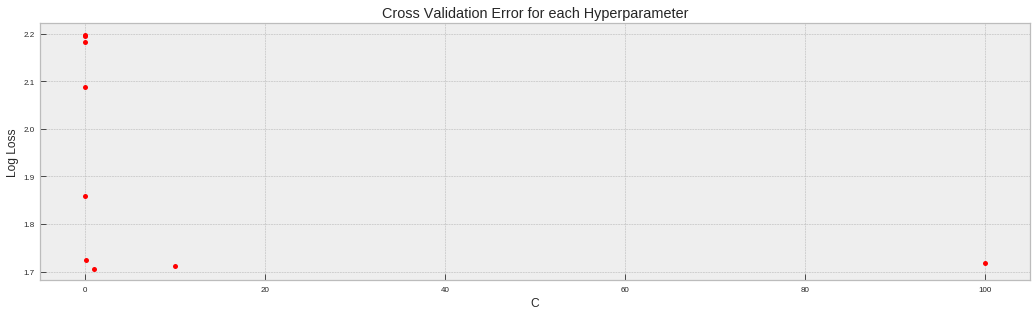

In [146]:
plot_hypP_vs_logloss(C, cv_log_loss_array, 'C')

Log loss on CV and Test using best C found

In [147]:
lr = LogisticRegression(C=best_C)
lr.fit(train_variation_feature_onehotCoding, y_train)

logloss_train = log_loss(y_train, lr.predict_proba(train_variation_feature_onehotCoding))
logloss_cv = log_loss(y_cv, lr.predict_proba(cv_variation_feature_onehotCoding))
logloss_test = log_loss(y_test, lr.predict_proba(test_variation_feature_onehotCoding))

print(logloss_train, logloss_cv, logloss_test)

print('For Logistic Regression using One-Hot-Encoding on feature Variation...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)


#table.add_row(['3','Variation', 'Test', 'One Hot Encoding', 'best C: {}'.format(best_C), 'Logistic Regression', np.round(logloss_test, 4)])

1.6125072038729173 1.706559368242411 1.7068766075533572
For Logistic Regression using One-Hot-Encoding on feature Variation...
****************************
logloss on train data:  1.6125072038729173
logloss on CV data:  1.706559368242411
logloss on Test data:  1.7068766075533572


Thus, when we used only Variation, the model yielded a logloss of 1.70 on Test data which is certainly better than the logloss of ~2.5 we obtained for a random model. Hence, we keep `Variation` too.

In [48]:
table.add_row(['3','Variation', 'Test', 'One Hot Encoding', 'best C: 1', 'Logistic Regression', 1.70])

## Univariate analysis : Text

`Text` is our final feature to analyze. 

### Most common words

Let's visualize the most common words belonging to each class. We first group the dataframe by `Class` and concatenate all the `Text` belonging to that class. And then Lemmatize the corpus.

In [149]:
corpus = df.groupby('Class').apply(lambda x: x['Text'].str.cat())

In [154]:
%%notify
%%time

wordnet_lemmatizer = WordNetLemmatizer()

corpus = corpus.apply(lambda x: Counter([wordnet_lemmatizer.lemmatize(w) 
                                                     for w in word_tokenize(x) 
                                                     if w.lower() not in stop_words and not w.isdigit()]))

CPU times: user 2min 53s, sys: 1.26 s, total: 2min 55s
Wall time: 2min 55s


<IPython.core.display.Javascript object>

Save to disk.

In [155]:
f = open('corpus_by_class-tokenized-lemmatized.pkl','wb')
pickle.dump(corpus, f)
f.close()

In [ ]:
# f = open('corpus_by_class-tokenized-lemmatized.pkl','rb')
# corpus = pickle.load(f)
# f.close()

In [156]:
print('Length of corpus: {}'.format(len(corpus)))
print('datatype of corpus: {}'.format(type(corpus)))

Length of corpus: 9
datatype of corpus: <class 'pandas.core.series.Series'>


Most common words in the corpus

In [157]:
corpus.sum().most_common(10)

[('mutat', 363780),
 ('cell', 297291),
 ('activ', 186469),
 ('mutant', 120114),
 ('protein', 118925),
 ('express', 118580),
 ('tumor', 114561),
 ('cancer', 111908),
 ('patient', 109752),
 ('gene', 99743)]

### Most common words found in the entire text

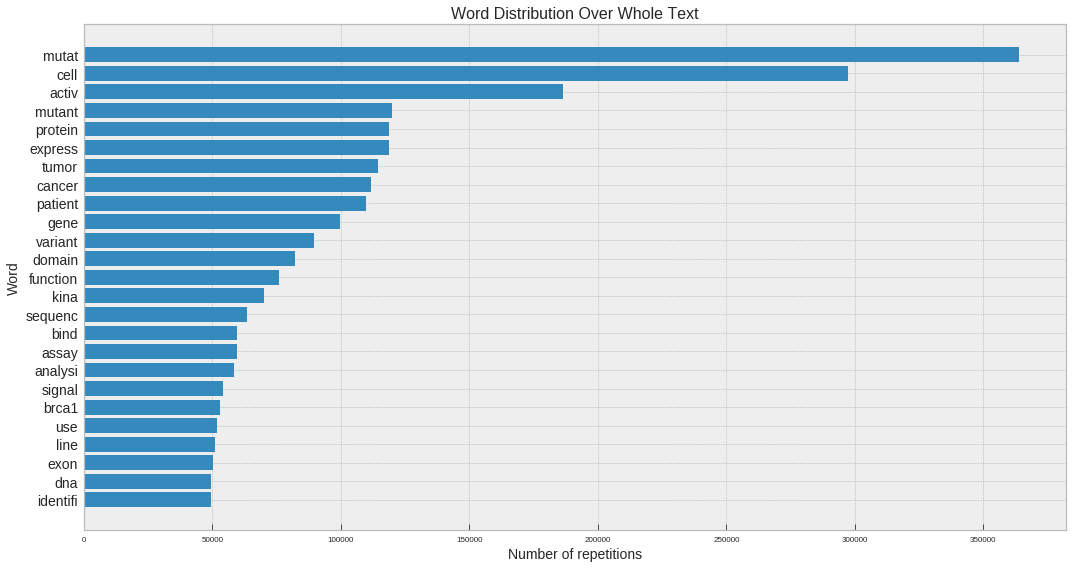

In [159]:
all_text_frequency = corpus.sum()
fig, ax = plt.subplots(figsize=(15,8))
label, repetition = zip(*all_text_frequency.most_common(25))
ax.barh(range(len(label)), repetition, align='center')
_ = ax.set_yticks(np.arange(len(label)))
_ = ax.set_yticklabels(label, fontsize=14)
ax.invert_yaxis()
ax.set_title('Word Distribution Over Whole Text', fontsize=16)
ax.set_xlabel('Number of repetitions', fontsize=14)
ax.set_ylabel('Word', fontsize=14)
plt.tight_layout()
plt.show()

#### Function to calculate word count of `Text` column in the dataframe

In [160]:
# cls_text is a data frame
# for every row in data fram consider the 'Text'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

#### Function to return the `response coding` features of feature `Text`.

In [161]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

#### TfidfVectorizer for feature `Text`

In [162]:
# building a TfidfVectorizer with maximum 25000 words that occured minimum 10 times in train data
text_vectorizer = TfidfVectorizer(max_features=100000, min_df=4)

# Get Tfidf value matrix of train data
train_text_feature_onehotCoding = text_vectorizer.fit_transform(df_X_train['Text'])

# Get all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
# The resulting 1D vector contains the sum of the tfidf value of each feature across all rows. 
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its summed Tfidf value
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52379


In [163]:
train_text_feature_onehotCoding

<2121x52379 sparse matrix of type '<class 'numpy.float64'>'
	with 2584268 stored elements in Compressed Sparse Row format>

In [164]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = df_X_train[df_X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(df_X_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

Response Coding Text features.

In [165]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(df_X_train)
test_text_feature_responseCoding  = get_text_responsecoding(df_X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(df_X_cv)

#### Standardize feature response coding for feature | Text

In [166]:
scaler = StandardScaler(with_mean=True)
train_text_feature_responseCoding = scaler.fit_transform(train_text_feature_responseCoding)
cv_text_feature_responseCoding = scaler.transform(cv_text_feature_responseCoding)
test_text_feature_responseCoding = scaler.transform(test_text_feature_responseCoding)

In [167]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(df_X_test['Text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(df_X_cv['Text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [168]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [169]:
# Number of words for a given frequency.
#print(Counter(sorted_text_occur))
sorted_text_occur.shape

(52379,)

#### How good is feature Text?

Let's obtain the optimal C and the important Text features.

In [170]:
C = [10 ** x for x in range(-6, 4)]

cv_log_loss_array, important_features_TEXT_LR = get_important_features(X_train=train_text_feature_onehotCoding, 
                                                                       X_cv=cv_text_feature_onehotCoding, 
                                                                       tfidf_vectorizer=text_vectorizer, 
                                                                       hyperparameters=C, 
                                                                       model='logistic regression')

In [171]:
print('For feature Text using 1Hot Encoding on Cross Validation data...\n')
for k, v in dict(zip(C, cv_log_loss_array)).items():
    print(' C = {}, logloss: {}'.format(k, v))

best_C = C[np.argmin(cv_log_loss_array)]
    
print('\nBest C found was:', best_C, 'with log loss: ', np.min(cv_log_loss_array))

For feature Text using 1Hot Encoding on Cross Validation data...

 C = 1e-06, logloss: 2.1970315968954672
 C = 1e-05, logloss: 2.1952942258639734
 C = 0.0001, logloss: 2.1779308739118566
 C = 0.001, logloss: 2.025360341346212
 C = 0.01, logloss: 1.474191829504542
 C = 0.1, logloss: 1.122239334565002
 C = 1, logloss: 1.2728819024962374
 C = 10, logloss: 1.6348312086949477
 C = 100, logloss: 2.2670705018640853
 C = 1000, logloss: 3.416472716389715

Best C found was: 0.1 with log loss:  1.122239334565002


Using feature Text alone for classification, best logloss obtained on CV was 1.12 which is not bad at all!

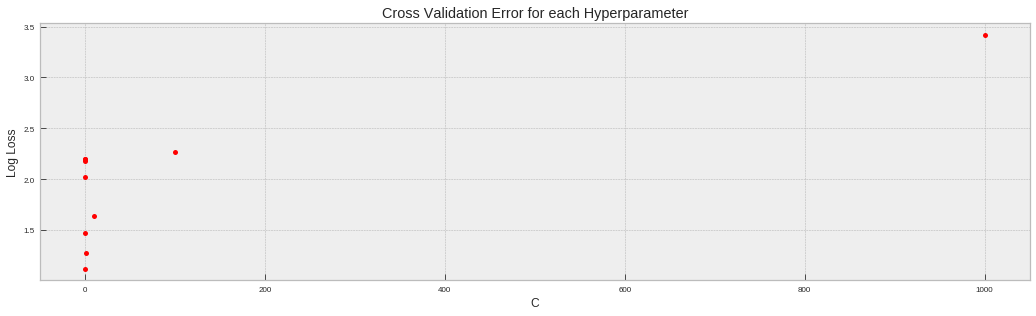

In [172]:
plot_hypP_vs_logloss(C, cv_log_loss_array, 'C')

In [173]:
lr = LogisticRegression(C= best_C)
lr.fit(train_text_feature_onehotCoding, y_train)

logloss_train = log_loss(y_train, lr.predict_proba(train_text_feature_onehotCoding))
logloss_cv = log_loss(y_cv, lr.predict_proba(cv_text_feature_onehotCoding))
logloss_test = log_loss(y_test, lr.predict_proba(test_text_feature_onehotCoding))

# print(logloss_train, logloss_cv, logloss_test)

print('For Logistic Regression using One-Hot-Encoding on feature Text...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)


# table.add_row(['4','Text', 'Test', 'One Hot Encoding', 'best C: {}'.format(best_C), 'Logistic Regression', np.round(logloss_test, 4)])

For Logistic Regression using One-Hot-Encoding on feature Text...
****************************
logloss on train data:  0.8140947093426852
logloss on CV data:  1.122239334565002
logloss on Test data:  1.092689796516829


Surprisingly, on Test data, logloss is further reduced to `1.092`. Univariate feature analysis is done. Before we start training the models on all features, let's define some functions.

In [49]:
table.add_row(['4','Text', 'Test', 'One Hot Encoding', 'best C: 0.1', 'Logistic Regression', 1.092])

In [174]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf, model):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = 5)
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Fraction of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y, model)

In [175]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=5)
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# Bigrams

Important bigram features according to logistic regression.

In [176]:
# Create bigram feature from Text

bigram_vec = TfidfVectorizer(ngram_range=(1,2), max_features=100000, min_df=3)

train_text_feature_bigram = bigram_vec.fit_transform(df_X_train['Text'])

cv_text_feature_bigram = bigram_vec.transform(df_X_cv['Text'])

test_text_feature_bigram = bigram_vec.transform(df_X_test['Text'])

In [177]:
train_text_feature_bigram.shape, cv_text_feature_bigram.shape, test_text_feature_bigram.shape

((2121, 100000), (531, 100000), (664, 100000))

### Combine the three features `Gene`, `Variation` and `Text` to begin training actual models

In [178]:
# merging gene, variance and text features

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))


train_x_bigram = hstack((train_gene_var_onehotCoding, train_text_feature_bigram)).tocsr()
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(df_X_train['Class']))

test_x_bigram = hstack((test_gene_var_onehotCoding, test_text_feature_bigram)).tocsr()

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(df_X_test['Class']))



cv_x_bigram = hstack((cv_gene_var_onehotCoding, cv_text_feature_bigram)).tocsr()

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(df_X_cv['Class']))

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [179]:
print("Bigram features :")
print("(number of data points * number of features) in train data = ", train_x_bigram.shape)
print("(number of data points * number of features) in test data = ", test_x_bigram.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_bigram.shape)

Bigram features :
(number of data points * number of features) in train data =  (2121, 100334)
(number of data points * number of features) in test data =  (664, 100334)
(number of data points * number of features) in cross validation data = (531, 100334)


In [180]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2121, 52713)
(number of data points * number of features) in test data =  (664, 52713)
(number of data points * number of features) in cross validation data = (531, 52713)


In [181]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2121, 27)
(number of data points * number of features) in test data =  (664, 27)
(number of data points * number of features) in cross validation data = (531, 27)


<!-- <p style="font-size:24px;text-align:Center"> <b>First model: Naive Bayes </b><p> -->

## Model 1 : Naive Bayes

First, find the important features of classification for Naive Bayes. 

In [182]:
alphas = [10 ** x for x in range(-6, 3)]

_, important_features_GENE_NB = get_important_features(X_train=train_gene_feature_onehotCoding, 
                                                                       X_cv=cv_gene_feature_onehotCoding, 
                                                                       tfidf_vectorizer=gene_vectorizer, 
                                                                       hyperparameters=alphas, 
                                                                       model='naive bayes')
_, important_features_VARIATION_NB = get_important_features(X_train=train_variation_feature_onehotCoding, 
                                                                       X_cv=cv_variation_feature_onehotCoding, 
                                                                       tfidf_vectorizer=variation_vectorizer, 
                                                                       hyperparameters=alphas, 
                                                                       model='naive bayes')
_, important_features_TEXT_NB = get_important_features(X_train=train_text_feature_onehotCoding, 
                                                                       X_cv=cv_text_feature_onehotCoding, 
                                                                       tfidf_vectorizer=text_vectorizer, 
                                                                       hyperparameters=alphas, 
                                                                       model='naive bayes')


Train and cross validate to find the optimal hyper-parameter

In [183]:
alphas = [10 ** x for x in range(-6, 5)]
cv_log_loss_array = train_cross_validate_on_X(train_x_onehotCoding, cv_x_onehotCoding, model='naive bayes', hyper_parameters=alphas)

In [184]:
# ALPHAS, cv_log_loss_array = NB_train_cross_validatate_on_X(train_x_onehotCoding, cv_x_onehotCoding)

print('For Naive Bayes on all features using 1 Hot Encoding for Cross Validation data...\n')
for k, v in dict(zip(alphas, cv_log_loss_array)).items():
    print(' alpha = {}, logloss: {}'.format(k, v))

best_alpha = alphas[np.argmin(cv_log_loss_array)]
    
print('\nBest alpha found was:',best_alpha , 'with log loss: ', np.min(cv_log_loss_array))

For Naive Bayes on all features using 1 Hot Encoding for Cross Validation data...

 alpha = 1e-06, logloss: 12.83151983184122
 alpha = 1e-05, logloss: 12.808558002305777
 alpha = 0.0001, logloss: 12.82875541692659
 alpha = 0.001, logloss: 12.891484315434022
 alpha = 0.01, logloss: 12.872526299602654
 alpha = 0.1, logloss: 12.283760519882087
 alpha = 1, logloss: 10.222171274095519
 alpha = 10, logloss: 7.073723521863401
 alpha = 100, logloss: 2.440918083144343
 alpha = 1000, logloss: 1.3296414615587813
 alpha = 10000, logloss: 1.7531261384517403

Best alpha found was: 1000 with log loss:  1.3296414615587813


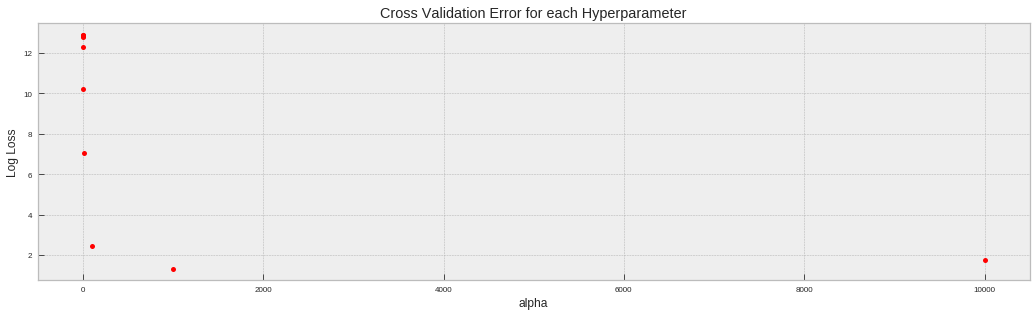

In [185]:
plot_hypP_vs_logloss(alphas, cv_log_loss_array, 'alpha')

Using the best found Hyper-parameter, find the logloss score on Test data.

In [187]:
nb = MultinomialNB(alpha= best_alpha)
nb.fit(train_x_onehotCoding, y_train)

logloss_train = log_loss(y_train, nb.predict_proba(train_x_onehotCoding))
logloss_cv = log_loss(y_cv, nb.predict_proba(cv_x_onehotCoding))
logloss_test = log_loss(y_test, nb.predict_proba(test_x_onehotCoding))

print('For Naive Bayes using One-Hot-Encoding features...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)

# table.field_names = ['#','Feature','Data Set','Feature Type','Hyperparameter', 'Algorithm','logloss']
# table.add_row(['5','All', 'Test', 'One Hot Encoding', 'best alpha: {}'.format(best_alpha), 'Naive Bayes', np.round(logloss_test, 4)])

For Naive Bayes using One-Hot-Encoding features...
****************************
logloss on train data:  1.18297050529059
logloss on CV data:  1.3296414615587813
logloss on Test data:  1.3294965711483997


### Plot the Confusion, Precision and Recall Matrix

Log loss : 1.1791325808225461
Fraction of mis-classified points : 0.423728813559322


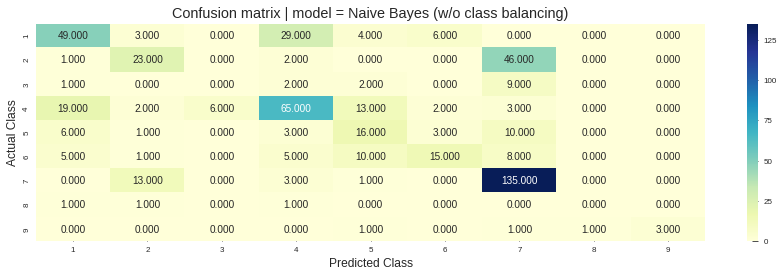

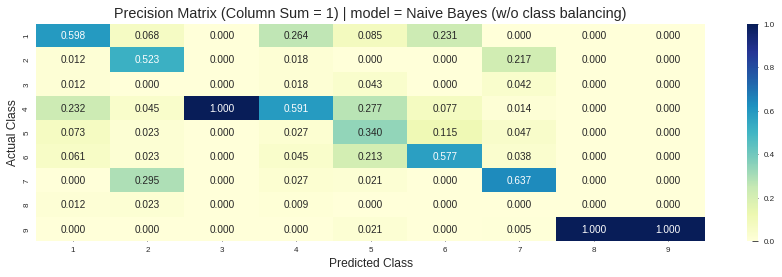

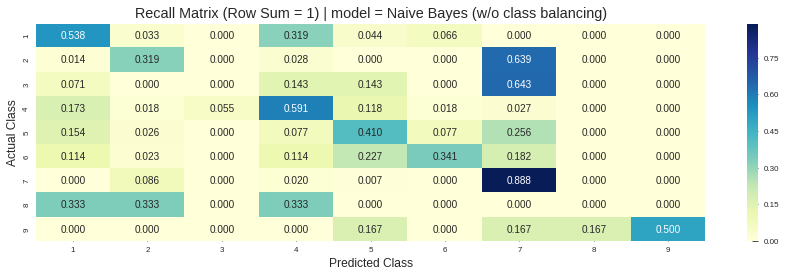

In [188]:
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, nb, model='Naive Bayes (w/o class balancing)')

In [50]:
table.add_row(['5','All', 'Test', 'One Hot Encoding', 'best alpha: 1000', 'Naive Bayes', 1.179])

### Understanding the model output : Correct classification

In [196]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=56, \
                               clf=nb,\
                               imp_feature_GENE = important_features_GENE_NB, \
                               imp_feature_VARIATION = important_features_VARIATION_NB, \
                               imp_feature_TEXT = important_features_TEXT_NB, \
                               top_n=50)

******************************Test Query Analysis******************************

Test data point: # 56
Predicted Probabilities of each class: 

[[0.288489   0.07569612 0.01487565 0.36822898 0.0405783  0.04573583
  0.15702403 0.00312895 0.00624315]]
Actual Class is:  4 
Predicted Class is 4
Class 4 was predicted because, among the top 50 words for this class, we found that:
TEXT: [protein] appeared [48] times which is the [#0] most important word
TEXT: [experi] appeared [3] times which is the [#1] most important word
TEXT: [indic] appeared [9] times which is the [#2] most important word
TEXT: [function] appeared [13] times which is the [#3] most important word
TEXT: [determin] appeared [5] times which is the [#6] most important word
TEXT: [result] appeared [8] times which is the [#7] most important word
TEXT: [acid] appeared [4] times which is the [#8] most important word
TEXT: [wherea] appeared [1] times which is the [#9] most important word
TEXT: [inactiv] appeared [6] times which is 

### Understanding the model output : Incorrect classification

In [193]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=43, \
                               clf=nb,\
                               imp_feature_GENE = important_features_GENE_NB, \
                               imp_feature_VARIATION = important_features_VARIATION_NB, \
                               imp_feature_TEXT = important_features_TEXT_NB, \
                               top_n=50)

******************************Test Query Analysis******************************

Test data point: # 43
Predicted Probabilities of each class: 

[[0.08866667 0.07654878 0.01804436 0.10838571 0.03900039 0.03872631
  0.62275887 0.00261984 0.00524908]]
Actual Class is:  3 
Predicted Class is 7
Class 7 was predicted because, among the top 50 words for this class, we found that:
TEXT: [cell] appeared [120] times which is the [#0] most important word
TEXT: [activ] appeared [17] times which is the [#1] most important word
TEXT: [express] appeared [16] times which is the [#2] most important word
TEXT: [downstream] appeared [1] times which is the [#3] most important word
TEXT: [kinas] appeared [12] times which is the [#5] most important word
TEXT: [presenc] appeared [5] times which is the [#6] most important word
TEXT: [suggest] appeared [10] times which is the [#7] most important word
TEXT: [increas] appeared [5] times which is the [#8] most important word
TEXT: [contrast] appeared [3] times wh

## Model 2 : K-Nearest Neighbors

Similar to what we did with Logistic Regression, the first step is Hyper Parameter tuning. But unlike LR, for KNN we have to calibrate the model to give probability outputs.

### Probability Calibration

When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction. Some models can give you poor estimates of the class probabilities and some even do not support probability prediction. The calibration module in `scikit-learn` allows you to better calibrate the probabilities of a given model, or to add support for probability prediction.

Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level.

We will use calibration on KNN for predicting the class probabilities which is a necessary condition we need to satisfy.

In [197]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]

cv_log_error_array = []

for k in alpha:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=5)
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("All feature | CV | Response Coding | KNN | Log Loss k={} : {}".format(k, log_loss(cv_y, sig_clf_probs)))
    

All feature | CV | Response Coding | KNN | Log Loss k=5 : 0.5967773480001233
All feature | CV | Response Coding | KNN | Log Loss k=11 : 0.5747414671109847
All feature | CV | Response Coding | KNN | Log Loss k=15 : 0.5904339443911636
All feature | CV | Response Coding | KNN | Log Loss k=21 : 0.6125890989689012
All feature | CV | Response Coding | KNN | Log Loss k=31 : 0.6525724526748615
All feature | CV | Response Coding | KNN | Log Loss k=41 : 0.6855919643779108
All feature | CV | Response Coding | KNN | Log Loss k=51 : 0.7309896419018739
All feature | CV | Response Coding | KNN | Log Loss k=99 : 0.8369944186291354


Plot K vs Log loss on CV data

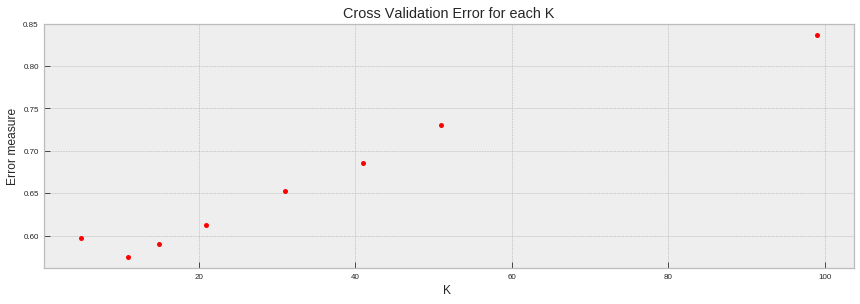

In [199]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='r', marker='.', linestyle='none', markersize=10)
plt.grid()
#plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each K")
plt.xlabel("K ")
plt.ylabel("Error measure")
plt.grid()
plt.show()

Log loss on Test data

In [201]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=5)
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)

print('All features | Response Coding | Train | KNN | best K = ', alpha[best_alpha], " The log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('All features | Response Coding | CV | KNN | best K = ', alpha[best_alpha], "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('All features | Response Coding | Test | KNN | best K = ', alpha[best_alpha], "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# table.add_row(['6','All', 'Test', 'Response Coding', 'best K: {}'.format(best_alpha), 'KNN', np.round(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15), 4)])

All features | Response Coding | Train | KNN | best K =  11  The log loss is: 0.40848308175132325
All features | Response Coding | CV | KNN | best K =  11 The log loss is: 0.5747414671109847
All features | Response Coding | Test | KNN | best K =  11 The log loss is: 0.567267122181435


Surprisingly, KNN which is the simplest classification model, gives the best log loss yet. Also, there's no overfitting. 

In [51]:
table.add_row(['6','All', 'Test', 'Response Coding', 'best K: 11', 'KNN', 0.567])

### Confusion, Precision and Recall Matrix for KNN

Log loss : 0.5747414671109847
Fraction of mis-classified points : 0.1713747645951036


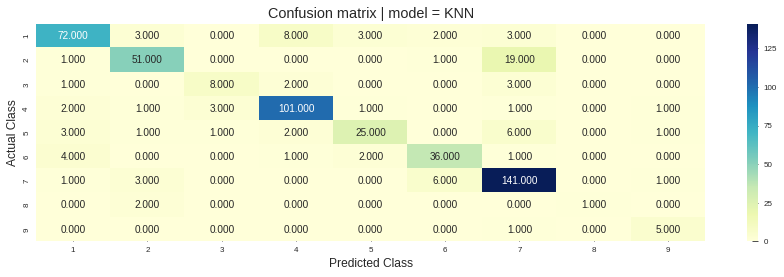

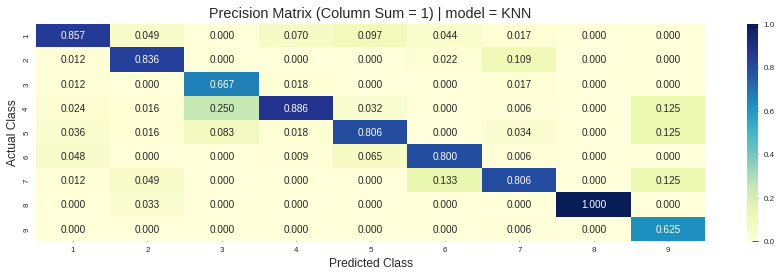

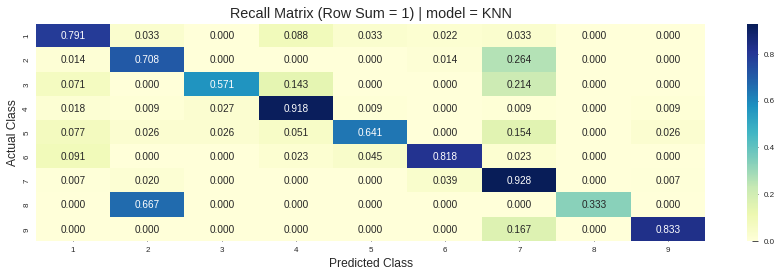

In [203]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf, 'KNN')

### Understanding the reason behind prediction : Incorrect Classification

Unfortunately, KNN can't tell us which features were responsible for classifying the query point into a particular class. It just gives us the class of its neighbors.  

In [211]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv =5)
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 19
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 2
The  11  nearest neighbours of the test points belongs to classes [2 2 2 2 7 4 7 7 2 2 7]
Fequency of nearest points : Counter({2: 6, 7: 4, 4: 1})


### Understanding the reason behind prediction : Correct Classification

In [207]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = 5)
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 11

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 4 1 4 4 4]
Fequency of nearest points : Counter({4: 10, 1: 1})


## Model 3 : Logistic Regresion With Class Balancing

Hyper parameter tuning

In [213]:
C = [10 ** x for x in range(-6, 4)]
cv_log_loss_array = train_cross_validate_on_X(train_x_onehotCoding, cv_x_onehotCoding, model='logistic regression', hyper_parameters=C, class_weight='balanced')

Log loss on CV data for various values of C

In [214]:
print('For All features using 1 Hot Encoding on Cross Validation data...\n')
for k, v in dict(zip(C, cv_log_loss_array)).items():
    print(' C = {}, logloss: {}'.format(k, v))

best_C = C[np.argmin(cv_log_loss_array)]
    
print('\nBest C found was:', best_C, 'with log loss: ', np.min(cv_log_loss_array))

For All features using 1 Hot Encoding on Cross Validation data...

 C = 1e-06, logloss: 2.196716048001084
 C = 1e-05, logloss: 2.192166911747444
 C = 0.0001, logloss: 2.148874090411739
 C = 0.001, logloss: 1.854627184347454
 C = 0.01, logloss: 1.270947014356653
 C = 0.1, logloss: 1.0848186506324031
 C = 1, logloss: 1.3276033001059317
 C = 10, logloss: 1.9168860184562515
 C = 100, logloss: 3.2920235294414164
 C = 1000, logloss: 4.766596384921868

Best C found was: 0.1 with log loss:  1.0848186506324031


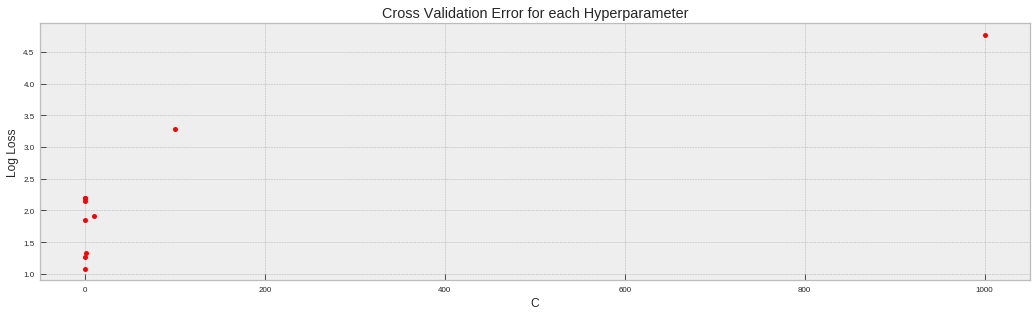

In [215]:
plot_hypP_vs_logloss(C, cv_log_loss_array, 'C')

Log loss on Test data

In [217]:
lr = LogisticRegression(C= best_C, class_weight='balanced')
lr.fit(train_x_onehotCoding, y_train)

logloss_train = log_loss(y_train, lr.predict_proba(train_x_onehotCoding))
logloss_cv = log_loss(y_cv, lr.predict_proba(cv_x_onehotCoding))
logloss_test = log_loss(y_test, lr.predict_proba(test_x_onehotCoding))

print('For Logistic Regression (with class balancing) using One-Hot-Encoding features...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)

# table.add_row(['7','All', 'Test', 'One Hot Encoding', 'best C: {}'.format(best_C), 'LR (class balanced)', np.round(logloss_test, 4)])

For Logistic Regression (with class balancing) using One-Hot-Encoding features...
****************************
logloss on train data:  0.5599171532069366
logloss on CV data:  1.0848186506324031
logloss on Test data:  1.0487441792212548


In [52]:
table.add_row(['7','All', 'Test', 'One Hot Encoding', 'best C: 0.1', 'LR with Class Balancing', 1.048])

### Confusion, Precision and Recall matrix

Log loss : 1.0115107110245536
Fraction of mis-classified points : 0.3615819209039548


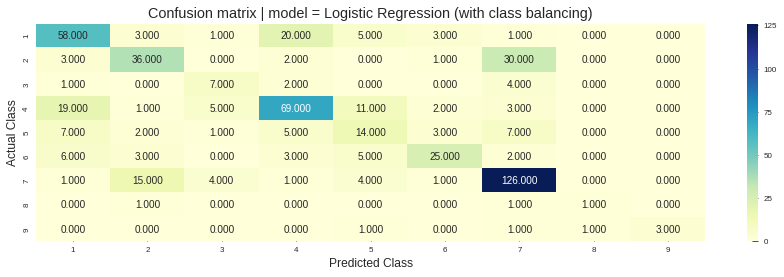

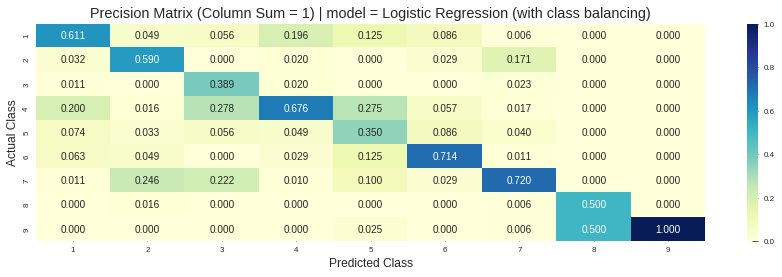

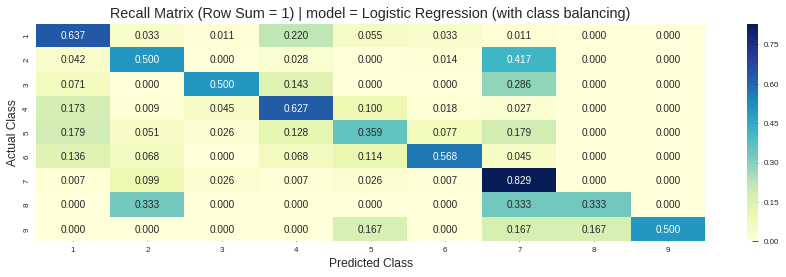

In [218]:
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, lr, model='Logistic Regression (with class balancing)')

### Understanding the reason behind prediction : Incorrect Classification

In [221]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=2, \
                               clf=lr,\
                               imp_feature_GENE = important_features_GENE_LR, \
                               imp_feature_VARIATION = important_features_VARIATION_LR, \
                               imp_feature_TEXT = important_features_TEXT_LR, \
                               top_n=500)

******************************Test Query Analysis******************************

Test data point: # 2
Predicted Probabilities of each class: 

[[0.16654183 0.01375407 0.00864212 0.33724708 0.43287483 0.00988859
  0.01346302 0.00894478 0.00864368]]
Actual Class is:  4 
Predicted Class is 5
Class 5 was predicted because, among the top 500 words for this class, we found that:
TEXT: [180000] appeared [1] times which is the [#84] most important word
TEXT: [variant] appeared [1] times which is the [#141] most important word
TEXT: [proliferationrel] appeared [1] times which is the [#218] most important word
TEXT: [antirad51] appeared [1] times which is the [#243] most important word
TEXT: [manuscript] appeared [1] times which is the [#255] most important word
TEXT: [assay] appeared [34] times which is the [#301] most important word
TEXT: [brca2] appeared [11] times which is the [#302] most important word
TEXT: [mayo] appeared [1] times which is the [#309] most important word
TEXT: [brca1] app

### Understanding the reason behind prediction : Correct Classification

In [223]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=221, \
                               clf=lr,\
                               imp_feature_GENE = important_features_GENE_LR, \
                               imp_feature_VARIATION = important_features_VARIATION_LR, \
                               imp_feature_TEXT = important_features_TEXT_LR, \
                               top_n=100)

******************************Test Query Analysis******************************

Test data point: # 221
Predicted Probabilities of each class: 

[[0.01036514 0.04885207 0.40571734 0.01098042 0.00717109 0.00811095
  0.4969013  0.00607929 0.00582243]]
Actual Class is:  7 
Predicted Class is 7
Class 7 was predicted because, among the top 100 words for this class, we found that:
TEXT: [constitut] appeared [93] times which is the [#0] most important word
TEXT: [transform] appeared [3] times which is the [#1] most important word
TEXT: [tyrosin] appeared [44] times which is the [#4] most important word
TEXT: [downstream] appeared [1] times which is the [#5] most important word
TEXT: [ligand] appeared [247] times which is the [#6] most important word
TEXT: [kinas] appeared [4] times which is the [#7] most important word
TEXT: [houston] appeared [1] times which is the [#8] most important word
TEXT: [phosphoryl] appeared [27] times which is the [#9] most important word
TEXT: [subcutan] appeared 

## Model 4 : Logistic Regression on bigram features

For this model, we will use bigram features of Text data while gene and Variation features will be unigram as before.

First, let's get important bigram features using a Logisitic Regression model.

In [224]:
C = [10 ** x for x in range(-6, 4)]

cv_log_loss_array, important_features_TEXTBIGRAM_LR = get_important_features(X_train=train_text_feature_bigram, 
                                                                       X_cv=cv_text_feature_bigram, 
                                                                       tfidf_vectorizer=bigram_vec, 
                                                                       hyperparameters=C, 
                                                                       model='logistic regression')

In [225]:
len(important_features_TEXTBIGRAM_LR)

9

Following are some of the important bigram features of class `3`

In [226]:
print(important_features_TEXTBIGRAM_LR['3'][:100])

['tsc1', 'tmprss2', 'fbxw7', 'caspase8', 'rad51c', 'chek2', 'nup93', 'pdgfra', 'ssa', 'erbb4', 'mtor', 'wtegfr', 'y537s', 'alk', 'mtor mutat', 'flt3', 'prostat', 'variant', 'phkd', 'prostat cancer', 'acc', 'podocyt', 'pkc412', 'baf3', 'dimer', 'tsc', 'hdr', 'brca1', 'fulvestr', 'azd9496', 'dacomitinib', 'tp53', 'v536e', 'rad51d', 'baf3 cell', 'rad51b', 'akt1', '1100delc', 'alk mutat', 'r834q', 'pdgfra mutat', 'receptor', 'melanoma', 'microg', 'egfrviii', 'y572c', 'ckit', 'notch1', 's451f', 'alk mutant', 'bph', 'v592g', 'tmprss2 gene', 'y572c v592g', 'hdr assay', 'alkf1174i', 'pbls', 'd538g', 'sporad prostat', 'cd95', 'ssa assay', 'brca1 variant', 'bmp7', 'alkm1166r', 'function', 'assay', 'cellsurfac', 'microg ml1', 'alkr1464stop', 'alkr1464stop', 'esr1', 'il3', 'wildtyp tsc1', 'tp53 mutat', 'neuroblastoma', 'pdgf', 'defect', 'human alk', 'l52r', 'v592g r834q', 'homolog recombin', 'neurit', 's463p', 'germlin tp53', 'cancer', 'e380q', 'alkf1174', 'alkf1174', 'imatinib mesyl', 'k935i', 'm

Train and cross validate

In [ ]:
cv_log_loss_array = train_cross_validate_on_X(train_x_bigram, cv_x_bigram, model='logistic regression', hyper_parameters=C)

Log loss on CV data

In [228]:
# C, cv_log_loss_array = LR_train_cross_validatate_on_X(train_x_bigram, cv_x_bigram)

print('For All features using 1 Hot Encoding on Cross Validation data...\n')
for k, v in dict(zip(C, cv_log_loss_array)).items():
    print(' C = {}, logloss: {}'.format(k, v))
    
best_C = C[np.argmin(cv_log_loss_array)]

print('\nBest C found was:', best_C, 'with log loss: ', np.min(cv_log_loss_array))

For All features using 1 Hot Encoding on Cross Validation data...

 C = 1e-06, logloss: 2.1967040137077154
 C = 1e-05, logloss: 2.192034883981123
 C = 0.0001, logloss: 2.147092319158033
 C = 0.001, logloss: 1.8498370112899347
 C = 0.01, logloss: 1.3168938181977687
 C = 0.1, logloss: 1.1161749914748438
 C = 1, logloss: 1.106597856905898
 C = 10, logloss: 1.2032563315135039
 C = 100, logloss: 1.5132801264190687
 C = 1000, logloss: 2.0288013255448627

Best C found was: 1 with log loss:  1.106597856905898


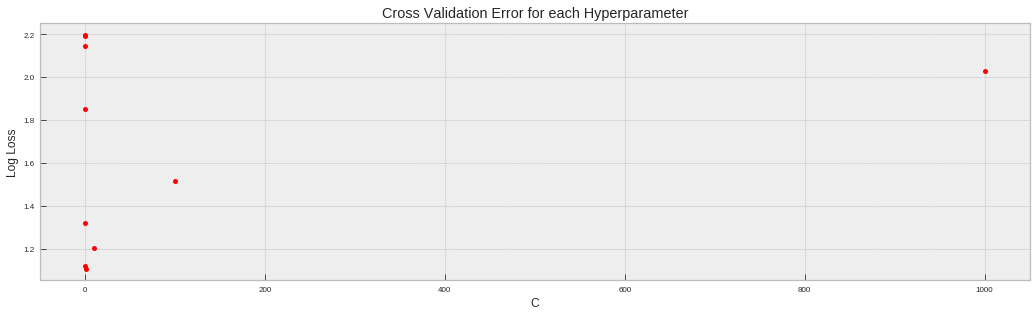

In [229]:
plot_hypP_vs_logloss(C, cv_log_loss_array, 'C')

Log loss on test data using Bigram Text features

In [231]:
lr = LogisticRegression(C= best_C)
lr.fit(train_x_bigram, y_train)

logloss_train = log_loss(y_train, lr.predict_proba(train_x_bigram))
logloss_cv = log_loss(y_cv, lr.predict_proba(cv_x_bigram))
logloss_test = log_loss(y_test, lr.predict_proba(test_x_bigram))

# print(logloss_train, logloss_cv, logloss_test)

print('For Logistic Regression using One-Hot-Encoding and Bigram features on Text...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)

# table.add_row(['8','All', 'Test', 'Text Bigrams', 'best C: {}'.format(best_C), 'Logistic Regression', np.round(logloss_test, 4)])

For Logistic Regression using One-Hot-Encoding and Bigram features on Text...
****************************
logloss on train data:  0.593991932967275
logloss on CV data:  1.106597856905898
logloss on Test data:  1.0917073701773063


In [53]:
table.add_row(['8','All', 'Test', 'Text Bigram', 'best C: 1', 'Logistic Regression', 1.091])

#### Confusion, Precision and Recall matrix

Log loss : 1.0660367905087738
Fraction of mis-classified points : 0.3822975517890772


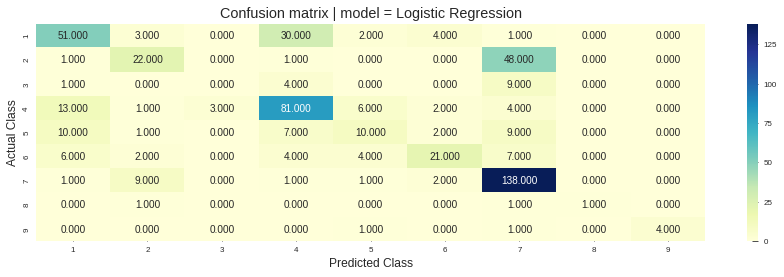

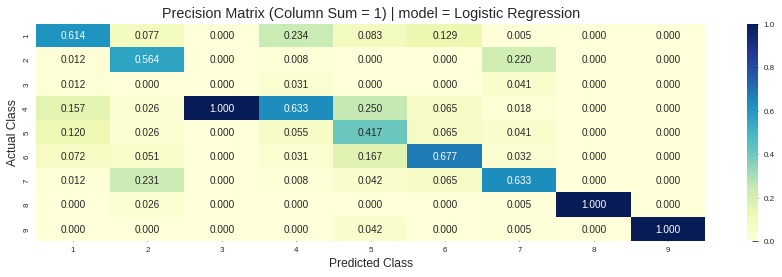

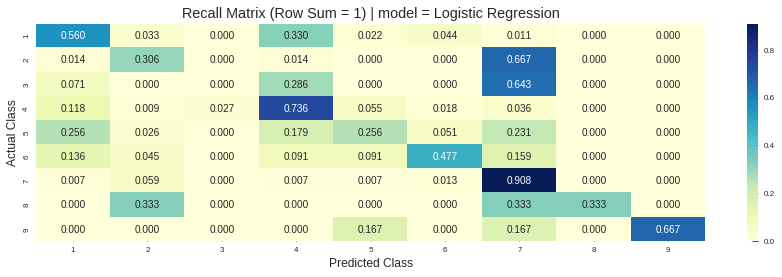

In [232]:
predict_and_plot_confusion_matrix(train_x_bigram, train_y, cv_x_bigram, cv_y, lr, model='Logistic Regression')

### Understanding the reason behind prediction : correct Classification

In [238]:
show_reasons_of_classification(test_x_bigram, \
                               test_point_index=56, \
                               clf=lr,\
                               imp_feature_GENE = important_features_GENE_LR, \
                               imp_feature_VARIATION = important_features_VARIATION_LR, \
                               imp_feature_TEXT = important_features_TEXTBIGRAM_LR, \
                               top_n=100)

******************************Test Query Analysis******************************

Test data point: # 56
Predicted Probabilities of each class: 

[[0.33189456 0.00252853 0.00176715 0.65453112 0.00214867 0.00206933
  0.00197093 0.00155574 0.00153397]]
Actual Class is:  4 
Predicted Class is 4
Class 4 was predicted because, among the top 100 words for this class, we found that:
TEXT: [smad4] appeared [108] times which is the [#21] most important word
TEXT: [mutant] appeared [6] times which is the [#25] most important word
TEXT: [tgfbr1] appeared [4] times which is the [#30] most important word
TEXT: [famili] appeared [1] times which is the [#51] most important word
TEXT: [protein] appeared [48] times which is the [#53] most important word
TEXT: [missens] appeared [37] times which is the [#57] most important word
TEXT: [germlin] appeared [1] times which is the [#61] most important word
TEXT: [function] appeared [13] times which is the [#65] most important word
TEXT: [mice] appeared [2] time

### Understanding the reason behind prediction : Incorrect Classification

In [241]:
show_reasons_of_classification(test_x_bigram, \
                               test_point_index=44, \
                               clf=lr,\
                               imp_feature_GENE = important_features_GENE_LR, \
                               imp_feature_VARIATION = important_features_VARIATION_LR, \
                               imp_feature_TEXT = important_features_TEXTBIGRAM_LR, \
                               top_n=100)

******************************Test Query Analysis******************************

Test data point: # 44
Predicted Probabilities of each class: 

[[0.2227429  0.00195245 0.0018582  0.01234207 0.53065516 0.22413912
  0.00282843 0.00175085 0.00173081]]
Actual Class is:  1 
Predicted Class is 5
Class 5 was predicted because, among the top 100 words for this class, we found that:
TEXT: [variant] appeared [49] times which is the [#4] most important word
TEXT: [vus] appeared [91] times which is the [#6] most important word
TEXT: [brca1] appeared [7] times which is the [#12] most important word
TEXT: [brca2] appeared [108] times which is the [#22] most important word
TEXT: [line] appeared [4] times which is the [#33] most important word
TEXT: [rare] appeared [5] times which is the [#43] most important word
TEXT: [neutral] appeared [13] times which is the [#55] most important word
TEXT: [assay] appeared [67] times which is the [#78] most important word
TEXT: [variat] appeared [1] times which is 

## Model 5 : Logistic Regresion Without Class Balancing

Hyper paramter Tuning

In [242]:
cv_log_loss_array = train_cross_validate_on_X(train_x_onehotCoding, cv_x_onehotCoding, model='logistic regression', hyper_parameters=C)

Log loss on CV data

In [244]:
print('For All features using 1 Hot Encoding on Cross Validation data...\n')
for k, v in dict(zip(C, cv_log_loss_array)).items():
    print(' C = {}, logloss: {}'.format(k, v))

best_C = C[np.argmin(cv_log_loss_array)]
    
print('\nBest C found was:', best_C, 'with log loss: ', np.min(cv_log_loss_array))

For All features using 1 Hot Encoding on Cross Validation data...

 C = 1e-06, logloss: 2.196600195972799
 C = 1e-05, logloss: 2.1909944039844134
 C = 0.0001, logloss: 2.1366819295468438
 C = 0.001, logloss: 1.7787062118179942
 C = 0.01, logloss: 1.1784779352499983
 C = 0.1, logloss: 1.0306547540449604
 C = 1, logloss: 1.293094058536766
 C = 10, logloss: 1.8840103012255152
 C = 100, logloss: 3.257682382150016
 C = 1000, logloss: 4.7356090919089775

Best C found was: 0.1 with log loss:  1.0306547540449604


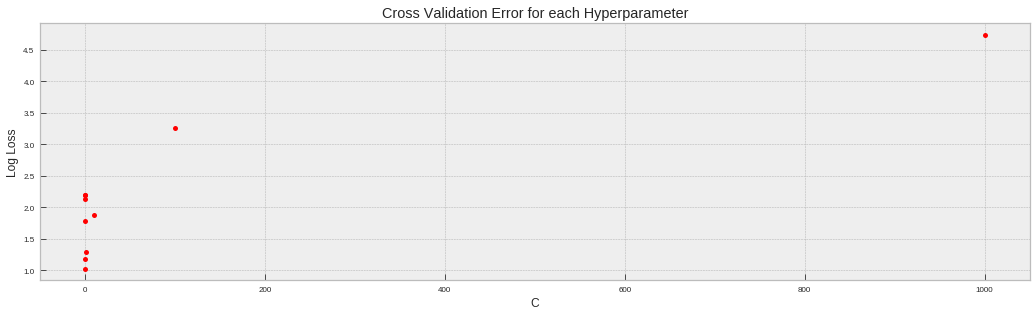

In [245]:
plot_hypP_vs_logloss(C, cv_log_loss_array, 'C')

Log loss on Test data

In [247]:
lr = LogisticRegression(C= best_C)
lr.fit(train_x_onehotCoding, y_train)

logloss_train = log_loss(y_train, lr.predict_proba(train_x_onehotCoding))
logloss_cv = log_loss(y_cv, lr.predict_proba(cv_x_onehotCoding))
logloss_test = log_loss(y_test, lr.predict_proba(test_x_onehotCoding))

# print(logloss_train, logloss_cv, logloss_test)

print('For Logistic Regression using One-Hot-Encoding features...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)

# table.add_row(['9','All', 'Test', 'One Hot Encoding', 'best C: {}'.format(best_C), 'Logistic Regression', np.round(logloss_test, 4)])

For Logistic Regression using One-Hot-Encoding features...
****************************
logloss on train data:  0.5265855699809584
logloss on CV data:  1.0306547540449604
logloss on Test data:  1.0049081117840015


Plot alpha vs log loss on CV data

In [54]:
table.add_row(['9','All', 'Test', 'One Hot Encoding', 'best C: 0.1', 'Logistic Regression', 1.00])

#### Confusion, Precision and Recall matrix

Log loss : 1.002624435934885
Fraction of mis-classified points : 0.35969868173258


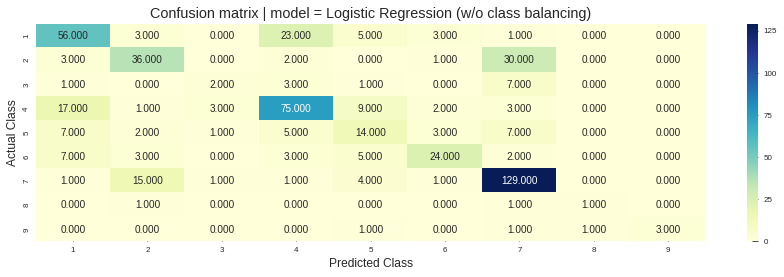

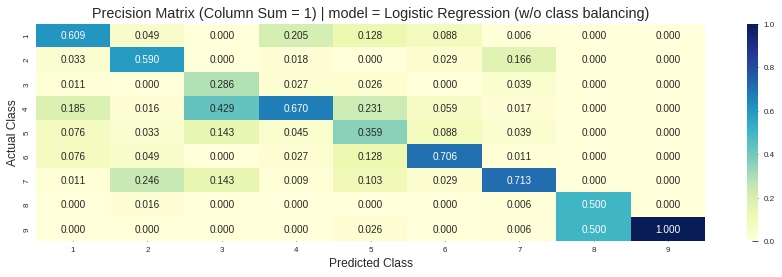

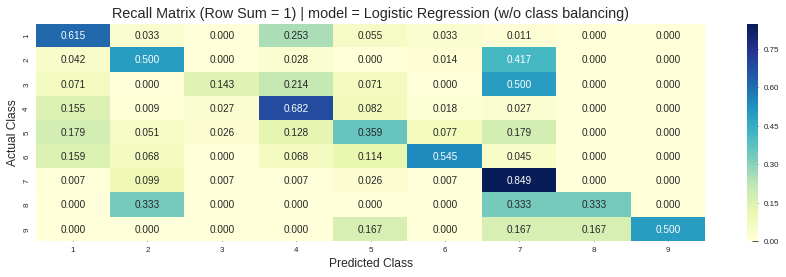

In [249]:
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, lr, model='Logistic Regression (w/o class balancing)')

### Understanding the reason behind prediction : correct Classification

In [250]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=168, \
                               clf=lr,\
                               imp_feature_GENE = important_features_GENE_LR, \
                               imp_feature_VARIATION = important_features_VARIATION_LR, \
                               imp_feature_TEXT = important_features_TEXT_LR, \
                               top_n=100)
                        #168        

******************************Test Query Analysis******************************

Test data point: # 168
Predicted Probabilities of each class: 

[[0.00922943 0.06043493 0.00605867 0.01331116 0.00715366 0.00706547
  0.88495158 0.00593803 0.00585707]]
Actual Class is:  7 
Predicted Class is 7
Class 7 was predicted because, among the top 100 words for this class, we found that:
TEXT: [constitut] appeared [5] times which is the [#0] most important word
TEXT: [transform] appeared [2] times which is the [#1] most important word
TEXT: [downstream] appeared [1] times which is the [#5] most important word
TEXT: [kinas] appeared [11] times which is the [#7] most important word
TEXT: [phosphoryl] appeared [45] times which is the [#9] most important word
TEXT: [oncogen] appeared [6] times which is the [#13] most important word
TEXT: [overexpress] appeared [2] times which is the [#24] most important word
TEXT: [serum] appeared [1] times which is the [#26] most important word
TEXT: [inhibitor] appea

### Understanding the reason behind prediction : Incorrect Classification

In [258]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=19, \
                               clf=lr,\
                               imp_feature_GENE = important_features_GENE_LR, \
                               imp_feature_VARIATION = important_features_VARIATION_LR, \
                               imp_feature_TEXT = important_features_TEXT_LR, \
                               top_n=100)
                        #168        

******************************Test Query Analysis******************************

Test data point: # 19
Predicted Probabilities of each class: 

[[3.02379252e-03 7.87004956e-02 3.59033801e-03 5.00659308e-03
  7.21678197e-04 3.81167037e-03 8.97725358e-01 3.65106232e-03
  3.76901216e-03]]
Actual Class is:  2 
Predicted Class is 7
Class 7 was predicted because, among the top 100 words for this class, we found that:
TEXT: [transform] appeared [13] times which is the [#1] most important word
TEXT: [3t3] appeared [4] times which is the [#2] most important word
TEXT: [downstream] appeared [1] times which is the [#5] most important word
TEXT: [oncogen] appeared [36] times which is the [#13] most important word
TEXT: [receptor] appeared [3] times which is the [#17] most important word
TEXT: [overexpress] appeared [1] times which is the [#24] most important word
TEXT: [inhibitor] appeared [1] times which is the [#27] most important word
TEXT: [activ] appeared [16] times which is the [#44] most im

## Model 5 : Linear SVM

First like we did for LR, find the important features of classification for SVM.

In [ ]:
_, important_features_GENE_SVM = get_important_features(X_train=train_gene_feature_onehotCoding, 
                                                                       X_cv=cv_gene_feature_onehotCoding, 
                                                                       tfidf_vectorizer=gene_vectorizer, 
                                                                       hyperparameters=C, 
                                                                       model='support vector machines')
_, important_features_VARIATION_SVM = get_important_features(X_train=train_variation_feature_onehotCoding, 
                                                                       X_cv=cv_variation_feature_onehotCoding, 
                                                                       tfidf_vectorizer=variation_vectorizer, 
                                                                       hyperparameters=C, 
                                                                       model='support vector machines')
_, important_features_TEXT_SVM = get_important_features(X_train=train_text_feature_onehotCoding, 
                                                                       X_cv=cv_text_feature_onehotCoding, 
                                                                       tfidf_vectorizer=text_vectorizer, 
                                                                       hyperparameters=C, 
                                                                       model='support vector machines')

Hyperparameter tuning

In [ ]:
cv_log_loss_array = train_cross_validate_on_X(train_x_onehotCoding, cv_x_onehotCoding, model='support vector machines', hyper_parameters=C)

Log loss on CV data

In [261]:
print('For All features using 1 Hot Encoding on Cross Validation data...\n')
for k, v in dict(zip(C, cv_log_loss_array)).items():
    print(' C = {}, logloss: {}'.format(k, v))

best_C = C[np.argmin(cv_log_loss_array)]
    
print('\nBest C found was:', best_C, 'with log loss: ', np.min(cv_log_loss_array))

For All features using 1 Hot Encoding on Cross Validation data...

 C = 1e-06, logloss: 1.222012186527827
 C = 1e-05, logloss: 1.2149935377883172
 C = 0.0001, logloss: 1.1814448636342283
 C = 0.001, logloss: 1.1647070211285295
 C = 0.01, logloss: 1.407143619628163
 C = 0.1, logloss: 1.6654937116364674
 C = 1, logloss: 2.184582446698581
 C = 10, logloss: 3.2021882877339998
 C = 100, logloss: 3.5869257441517473
 C = 1000, logloss: 3.6680783080355903

Best C found was: 0.001 with log loss:  1.1647070211285295


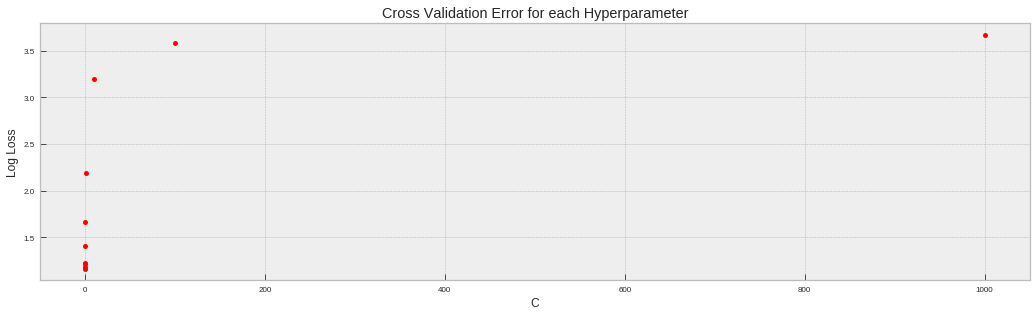

In [262]:
plot_hypP_vs_logloss(C, cv_log_loss_array, 'C')

Log Loss on Test data

In [264]:
svm = LinearSVC(C= best_C)
svm.fit(train_x_onehotCoding, y_train)

cal_clf = CalibratedClassifierCV(svm, method="sigmoid", cv='prefit')
cal_clf.fit(train_x_onehotCoding, y_train)

logloss_train = log_loss(y_train, cal_clf.predict_proba(train_x_onehotCoding))
logloss_cv = log_loss(y_cv, cal_clf.predict_proba(cv_x_onehotCoding))
logloss_test = log_loss(y_test, cal_clf.predict_proba(test_x_onehotCoding))

print(logloss_train, logloss_cv, logloss_test)

print('For Linear SVM using One-Hot-Encoded features...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)

# table.add_row(['10','All', 'Test', 'One Hot Encoding', 'best C: {}'.format(best_C), 'Linear SVM', np.round(logloss_test, 4)])

0.682279691335384 1.1647069845767382 1.1041344867968454
For Linear SVM using One-Hot-Encoded features...
****************************
logloss on train data:  0.682279691335384
logloss on CV data:  1.1647069845767382
logloss on Test data:  1.1041344867968454


In [55]:
table.add_row(['10','All', 'Test', 'One Hot Encoding', 'best C: 0.001', 'Linear SVM', 1.10])

### Confusion, Precision and Recall matrix

Log loss : 1.087463561294585
Fraction of mis-classified points : 0.3992467043314501


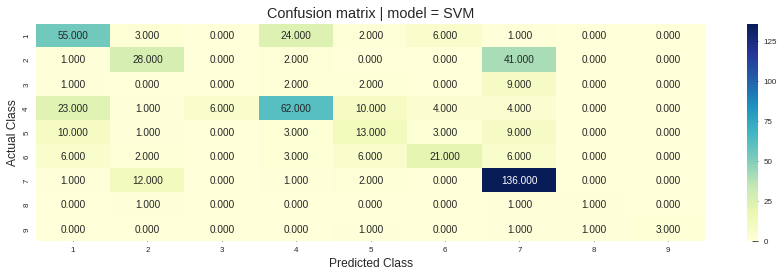

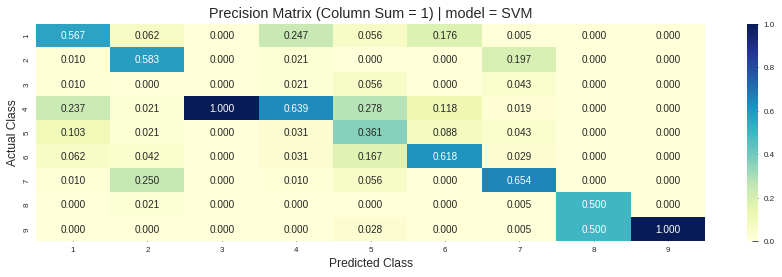

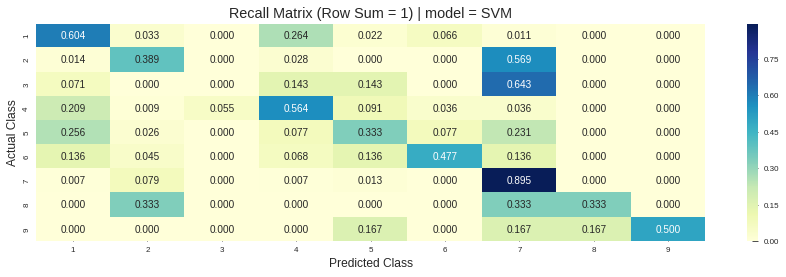

In [265]:
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, svm, model='SVM')

### Understanding the reason behind prediction : correct Classification

In [273]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=132, \
                               clf=cal_clf,\
                               imp_feature_GENE = important_features_GENE_SVM, \
                               imp_feature_VARIATION = important_features_VARIATION_SVM, \
                               imp_feature_TEXT = important_features_TEXT_SVM, \
                               top_n=100)
                        #168        

******************************Test Query Analysis******************************

Test data point: # 132
Predicted Probabilities of each class: 

[[0.02817739 0.30628415 0.00731684 0.02543228 0.17112609 0.01649507
  0.44045616 0.00295044 0.00176157]]
Actual Class is:  7 
Predicted Class is 7
Class 7 was predicted because, among the top 100 words for this class, we found that:
TEXT: [constitut] appeared [22] times which is the [#0] most important word
TEXT: [transform] appeared [63] times which is the [#1] most important word
TEXT: [3t3] appeared [12] times which is the [#2] most important word
TEXT: [tyrosin] appeared [11] times which is the [#4] most important word
TEXT: [ligand] appeared [30] times which is the [#5] most important word
TEXT: [downstream] appeared [9] times which is the [#7] most important word
TEXT: [phosphoryl] appeared [95] times which is the [#8] most important word
TEXT: [nude] appeared [14] times which is the [#10] most important word
TEXT: [subcutan] appeared [5

### Understanding the reason behind prediction : Incorrect Classification

In [275]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=98, \
                               clf=cal_clf,\
                               imp_feature_GENE = important_features_GENE_SVM, \
                               imp_feature_VARIATION = important_features_VARIATION_SVM, \
                               imp_feature_TEXT = important_features_TEXT_SVM, \
                               top_n=100)
                        #168        

******************************Test Query Analysis******************************

Test data point: # 98
Predicted Probabilities of each class: 

[[0.3330068  0.0108944  0.00468761 0.17823493 0.43395221 0.03197802
  0.00443084 0.00170797 0.00110722]]
Actual Class is:  4 
Predicted Class is 5
Class 5 was predicted because, among the top 100 words for this class, we found that:
TEXT: [brca1brct] appeared [1] times which is the [#12] most important word


## Model 6 : Random Forest Classifier

Let's get the important features for RFC

In [ ]:
%%notify
%%time

_, important_features_GENE_RF = get_important_features_RF(train_gene_feature_onehotCoding,
                                                       cv_gene_feature_onehotCoding, 
                                                       gene_vectorizer)

_, important_features_VARIATION_RF = get_important_features_RF(train_variation_feature_onehotCoding,
                                                            cv_variation_feature_onehotCoding,
                                                            variation_vectorizer)

_,important_features_TEXT_RF = get_important_features_RF(train_text_feature_onehotCoding,
                                                       cv_text_feature_onehotCoding, 
                                                       text_vectorizer)

Save the variables to disk

In [279]:
f = open('important_features_GENE_RF.pkl', 'wb')
pickle.dump(important_features_GENE_RF, f)
f.close()

f = open('important_features_VARIATION_RF.pkl', 'wb')
pickle.dump(important_features_VARIATION_RF, f)
f.close()

f = open('important_features_TEXT_RF.pkl', 'wb')
pickle.dump(important_features_TEXT_RF, f)
f.close()

In [ ]:
# f = open('important_features_GENE_RF.pkl', 'rb')
# important_features_GENE_RF = pickle.load(f)
# f.close()

# f = open('important_features_VARIATION_RF.pkl', 'rb')
# important_features_VARIATION_RF = pickle.load(f)
# f.close()

# f = open('important_features_TEXT_RF.pkl', 'rb')
# important_features_TEXT_RF = pickle.load(f)
# f.close()

Train and cross validate to find the best hyper-parameters

In [ ]:
%%notify
%%time

hyp_par = {
            'max_depth':[3,5,7,9,11, 15, 20, 30, 35, 50],
            'n_estimators' : [10, 30, 50, 70, 90, 130, 150, 200, 300]
}

cv_log_loss_array = train_cross_validate_on_X(train_x_onehotCoding, cv_x_onehotCoding, model='random forests', hyper_parameters=hyp_par)

Log loss on Test data

In [283]:
rfc = RandomForestClassifier(n_estimators = 300 , max_depth = 20)
rfc.fit(train_x_onehotCoding, y_train)

#cal_clf = CalibratedClassifierCV(svm, method="sigmoid", cv='prefit')
#cal_clf.fit(train_x_onehotCoding, y_train)

logloss_train = log_loss(y_train, rfc.predict_proba(train_x_onehotCoding))
logloss_cv = log_loss(y_cv, rfc.predict_proba(cv_x_onehotCoding))
logloss_test = log_loss(y_test, rfc.predict_proba(test_x_onehotCoding))

# print(logloss_train, logloss_cv, logloss_test)

print('For Random Forest using One-Hot-Encoded features...', end = '\n****************************\n')
print('logloss on train data: ', logloss_train)
print('logloss on CV data: ', logloss_cv)
print('logloss on Test data: ', logloss_test)

# table.add_row(['11','All', 'Test', 'One Hot Encoding', 'best C: {}'.format(best_C), 'Random Forests', np.round(logloss_test, 4)])

For Random Forest using One-Hot-Encoded features...
****************************
logloss on train data:  0.4299101856271784
logloss on CV data:  1.233074655991598
logloss on Test data:  1.1900314885641523


In [56]:
table.add_row(['11','All', 'Test', 'One Hot Encoding', 'best estimators/depth:300/20', 'Random Forests', 1.19])

### Confusion, Precision and Recall Matrix

Log loss : 1.218903445018649
Fraction of mis-classified points : 0.4143126177024482


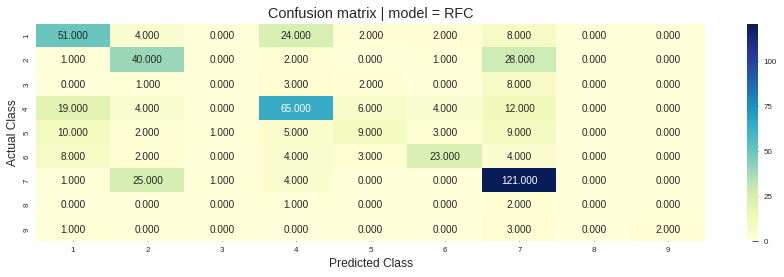

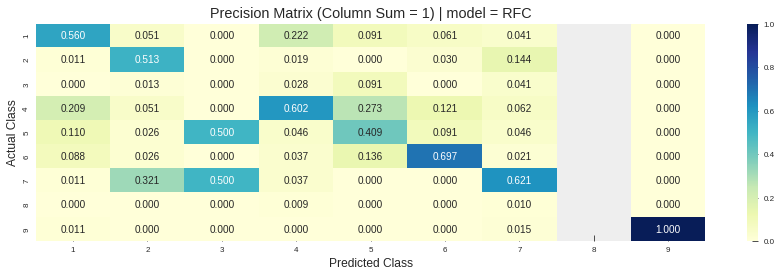

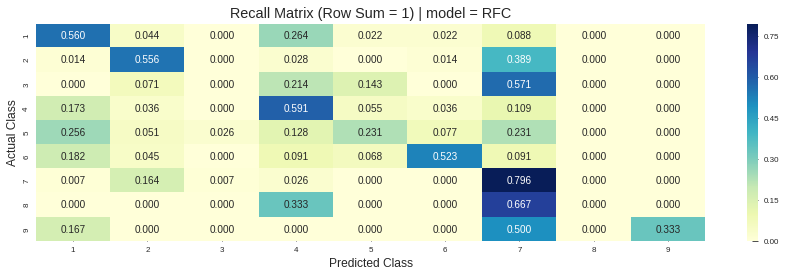

In [284]:
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, rfc, model='RFC')

### Understanding the reason behind prediction : correct Classification

In [285]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=168, \
                               clf=rfc,\
                               imp_feature_GENE = important_features_GENE_RF, \
                               imp_feature_VARIATION = important_features_VARIATION_RF, \
                               imp_feature_TEXT = important_features_TEXT_RF, \
                               top_n=100)
                        #168        

******************************Test Query Analysis******************************

Test data point: # 168
Predicted Probabilities of each class: 

[[0.12426253 0.09737717 0.01517624 0.17367088 0.04647441 0.03209615
  0.49488769 0.00738879 0.00866614]]
Actual Class is:  7 
Predicted Class is 7
Class 7 was predicted because, among the top 100 words for this class, we found that:
TEXT: [kinas] appeared [11] times which is the [#0] most important word
TEXT: [suppressor] appeared [8] times which is the [#1] most important word
TEXT: [inhibitor] appeared [12] times which is the [#2] most important word
TEXT: [phosphoryl] appeared [45] times which is the [#3] most important word
TEXT: [downstream] appeared [1] times which is the [#4] most important word
TEXT: [missens] appeared [5] times which is the [#5] most important word
TEXT: [harbor] appeared [1] times which is the [#9] most important word
TEXT: [constitut] appeared [5] times which is the [#11] most important word
TEXT: [signal] appeared 

### Understanding the reason behind prediction : Incorrect Classification

In [294]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=101, \
                               clf=rfc,\
                               imp_feature_GENE = important_features_GENE_RF, \
                               imp_feature_VARIATION = important_features_VARIATION_RF, \
                               imp_feature_TEXT = important_features_TEXT_RF, \
                               top_n=100)
                        #168        

******************************Test Query Analysis******************************

Test data point: # 101
Predicted Probabilities of each class: 

[[0.06207625 0.11511664 0.02228974 0.07725205 0.06178812 0.20172474
  0.45296417 0.00173013 0.00505815]]
Actual Class is:  6 
Predicted Class is 7
Class 7 was predicted because, among the top 100 words for this class, we found that:
TEXT: [kinas] appeared [16] times which is the [#0] most important word
TEXT: [inhibitor] appeared [2] times which is the [#2] most important word
TEXT: [phosphoryl] appeared [10] times which is the [#3] most important word
TEXT: [downstream] appeared [4] times which is the [#4] most important word
TEXT: [missens] appeared [19] times which is the [#5] most important word
TEXT: [erk] appeared [17] times which is the [#7] most important word
TEXT: [constitut] appeared [4] times which is the [#11] most important word
TEXT: [signal] appeared [2] times which is the [#13] most important word
TEXT: [therapi] appeared [1] 

## Model 7 : Random Forests (With Response Coding)

In [297]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]

ind = 0

cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j, end = ' | ')
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=3)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = 5)
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        ind += 1
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 10 and max depth =  2 | Log Loss : 0.2987059661508599
for n_estimators = 10 and max depth =  3 | Log Loss : 0.21473203488116321
for n_estimators = 10 and max depth =  5 | Log Loss : 0.10512503813660742
for n_estimators = 10 and max depth =  10 | Log Loss : 0.07027867973072967
for n_estimators = 50 and max depth =  2 | Log Loss : 0.1900904095304813
for n_estimators = 50 and max depth =  3 | Log Loss : 0.14910711681086153
for n_estimators = 50 and max depth =  5 | Log Loss : 0.08423006461682993
for n_estimators = 50 and max depth =  10 | Log Loss : 0.06348726874252268
for n_estimators = 100 and max depth =  2 | Log Loss : 0.1765225409176861
for n_estimators = 100 and max depth =  3 | Log Loss : 0.1422639989044061
for n_estimators = 100 and max depth =  5 | Log Loss : 0.08340626459758309
for n_estimators = 100 and max depth =  10 | Log Loss : 0.06468415741673735
for n_estimators = 200 and max depth =  2 | Log Loss : 0.15725537287914645
for n_estimators = 200 and max dep

Log Loss on test data using the best hyperparameter

In [298]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=2)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = 5)
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)

print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  50 The train log loss is: 0.03568148280621323
For values of best alpha =  50 The cross validation log loss is: 0.06348726874252268
For values of best alpha =  50 The test log loss is: 0.06433758298358887


In [57]:
table.add_row(['12','All', 'Test', 'Response Coding', 'best estimators/depth:1000/10', 'Random Forests', 0.0643])

#### Confusion, Precision and Recall matrix

Log loss : 0.06348726874252268
Fraction of mis-classified points : 0.013182674199623353


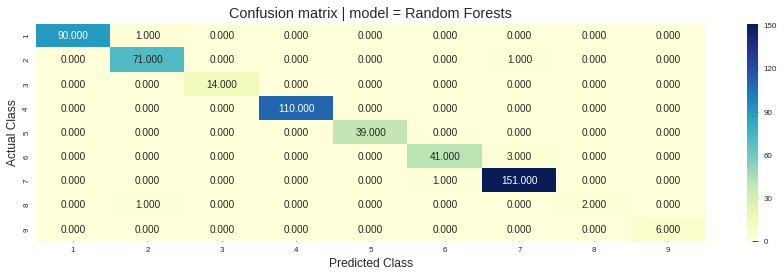

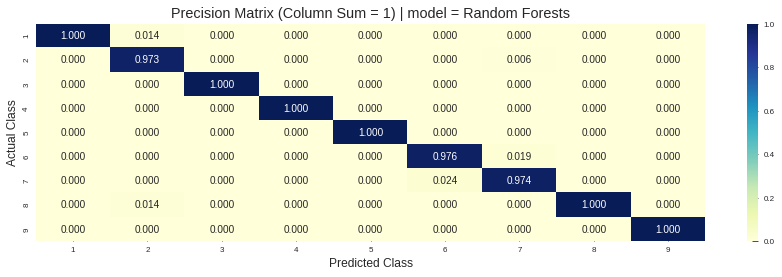

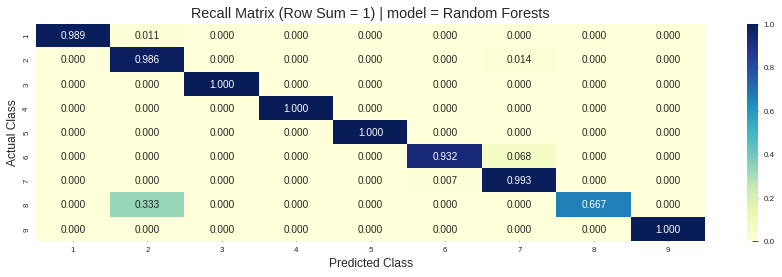

In [300]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf, model = 'Random Forests')

### Understanding the reason behind prediction : Incorrect Classification

In [307]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=18, \
                               clf=rfc,\
                               imp_feature_GENE = important_features_GENE_RF, \
                               imp_feature_VARIATION = important_features_VARIATION_RF, \
                               imp_feature_TEXT = important_features_TEXT_RF, \
                               top_n=100)
                        #168        

******************************Test Query Analysis******************************

Test data point: # 18
Predicted Probabilities of each class: 

[[0.05319012 0.36244158 0.01127136 0.05388601 0.02610832 0.0282681
  0.45229537 0.0057918  0.00674734]]
Actual Class is:  2 
Predicted Class is 7
Class 7 was predicted because, among the top 100 words for this class, we found that:
TEXT: [kinas] appeared [25] times which is the [#0] most important word
TEXT: [suppressor] appeared [1] times which is the [#1] most important word
TEXT: [inhibitor] appeared [36] times which is the [#2] most important word
TEXT: [phosphoryl] appeared [7] times which is the [#3] most important word
TEXT: [respond] appeared [1] times which is the [#6] most important word
TEXT: [erk] appeared [2] times which is the [#7] most important word
TEXT: [resist] appeared [33] times which is the [#8] most important word
TEXT: [harbor] appeared [23] times which is the [#9] most important word
TEXT: [constitut] appeared [1] times

### Understanding the reason behind prediction : correct Classification

In [306]:
show_reasons_of_classification(test_x_onehotCoding, \
                               test_point_index=1, \
                               clf=rfc,\
                               imp_feature_GENE = important_features_GENE_RF, \
                               imp_feature_VARIATION = important_features_VARIATION_RF, \
                               imp_feature_TEXT = important_features_TEXT_RF, \
                               top_n=100)
                        #168        

******************************Test Query Analysis******************************

Test data point: # 1
Predicted Probabilities of each class: 

[[4.54346461e-02 1.15052296e-01 4.62949472e-03 3.12366581e-02
  1.80515941e-02 5.94904634e-01 1.63591666e-01 2.68870571e-02
  2.11954608e-04]]
Actual Class is:  6 
Predicted Class is 6
Class 6 was predicted because, among the top 100 words for this class, we found that:
TEXT: [kinas] appeared [78] times which is the [#0] most important word
TEXT: [inhibitor] appeared [27] times which is the [#2] most important word
TEXT: [phosphoryl] appeared [19] times which is the [#3] most important word
TEXT: [respond] appeared [1] times which is the [#6] most important word
TEXT: [erk] appeared [5] times which is the [#7] most important word
TEXT: [resist] appeared [111] times which is the [#8] most important word
TEXT: [constitut] appeared [1] times which is the [#11] most important word
TEXT: [autophosphoryl] appeared [4] times which is the [#12] most imp

## Model 8 : Stacking Classifer

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble.

In [308]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0, max_iter=1000, tol=1e-3)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid", cv =5)

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0, max_iter=1000, tol=1e-3)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid", cv=5)


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid", cv =5)

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error = np.round(log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding)), 4)
    
    # table.add_row([table_indexes[ind],'All 3', 'CV', 'OneHotEncoding', 'C: '+str(i), 'Stacking Classifier \n(LR+SVM+NB)',log_error])
    
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.03
Support vector machines : Log Loss: 1.21
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.177
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.023
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.479
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.096
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.141
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.358


In [58]:
table.add_row(['13','All', 'Test', 'One Hot Encoding', ' - ', 'Stacking: LR+SVM+NB', 1.106])

### Confusion, Precision and Recall matrix

Log loss (train) on the stacking classifier : 0.6567025482787822
Log loss (CV) on the stacking classifier : 1.0958209607545704
Log loss (test) on the stacking classifier : 1.1068306272439816
Number of missclassified point : 0.375


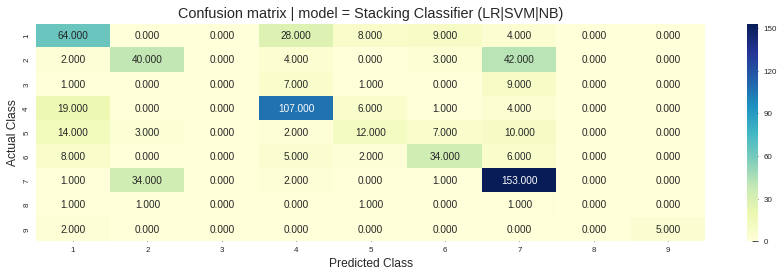

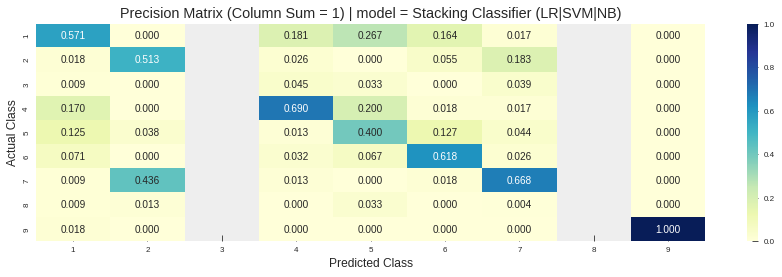

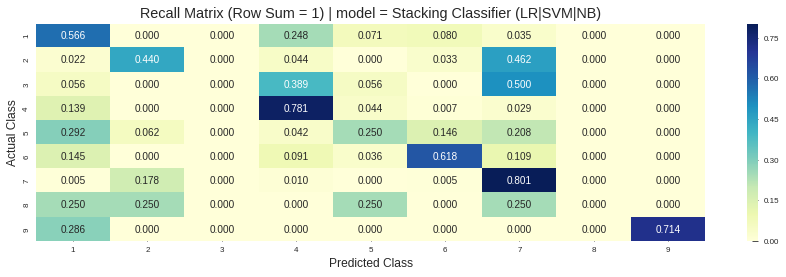

In [310]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, sclf.predict(test_x_onehotCoding), model = 'Stacking Classifier (LR|SVM|NB)')

## Model 9 :  Voting classifier

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

Log loss (train) on the VotingClassifier : 0.7570640977752613
Log loss (CV) on the VotingClassifier : 1.08795594321124
Log loss (test) on the VotingClassifier : 1.0894708710604404
Number of missclassified point : 0.3644578313253012


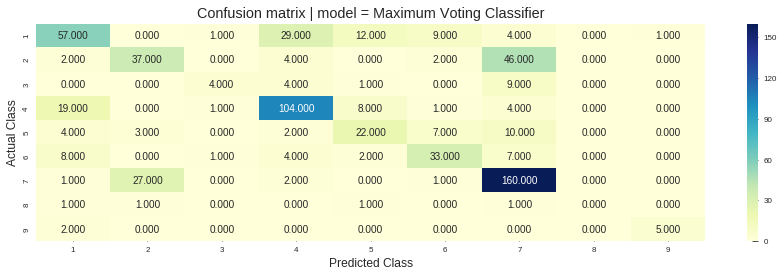

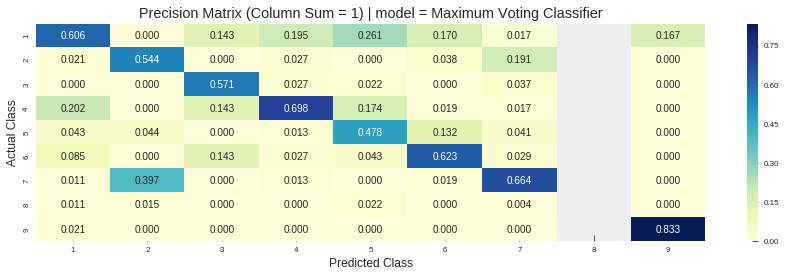

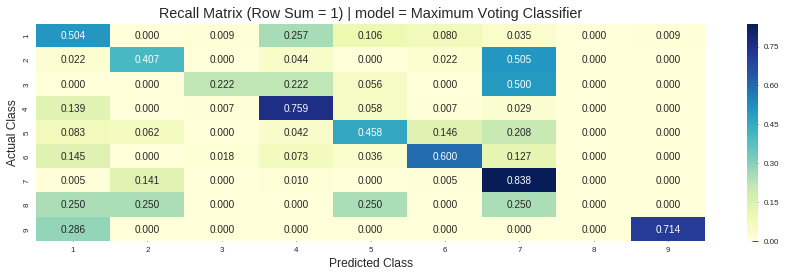

In [311]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(y_test=test_y, y_predicted=vclf.predict(test_x_onehotCoding), model = 'Maximum Voting Classifier')

In [59]:
table.add_row(['14','All', 'Test', 'One Hot Encoding', ' - ', 'Voting: LR+SVM+NB', 1.089])

# Conclusion

* We began with raw data in the form of two flat files containing training Gene, variants and Text data and finally arrived at several models, which do a pretty decent job of classifying the data correctly in one of the nine classes without any human intervention, thus automating the laborious third phase of the job discussed in the opening section of this notebook.  
* We discussed 9 different models with varying degrees of strength and weaknesses. However, the optimal logloss of `0.0643` was obtained for Random Forests with Response Coding. It classified only 1.32% points incorrectly. KNN performed second best with logloss of `0.567` and it misclassified 17.13% points (For a consolidated summary of all models, please see the following table)

* Most importantly, we were able to come up with a system, which explains the reasoning behind the classification in terms of the important features found in the query point. 

In [60]:
print(table)

+----+-----------+----------+------------------+-------------------------------+-------------------------+---------+
| #  |  Feature  | Data Set |   Feature Type   |         Hyperparameter        |        Algorithm        | logloss |
+----+-----------+----------+------------------+-------------------------------+-------------------------+---------+
| 1  |     NA    |   Test   |        NA        |               NA              |    Random Prediction    |   2.48  |
| 2  |    Gene   |   Test   | One Hot Encoding |          best C: 0.1          |   Logistic Regression   |  1.234  |
| 3  | Variation |   Test   | One Hot Encoding |           best C: 1           |   Logistic Regression   |   1.7   |
| 4  |    Text   |   Test   | One Hot Encoding |          best C: 0.1          |   Logistic Regression   |  1.092  |
| 5  |    All    |   Test   | One Hot Encoding |        best alpha: 1000       |       Naive Bayes       |  1.179  |
| 6  |    All    |   Test   | Response Coding  |           best 